In [8]:
import ee
from google.oauth2 import service_account

import numpy as np
import pandas as pd
import scipy.signal
import matplotlib.pyplot as plt
import geetools
import eemont
import geemap
from ee_extra.TimeSeries.core import getTimeSeriesByRegion
from PIL import Image
from plot_ee_fctns import get_image_index, box_around_point, mask_other, initialise_comparison
from masks import mask_MODIS_clouds, MODIS_Mask_QC, mask_s2_clouds, mask_s2_clouds_collection, csPlus_mask_collection, MODIS_mask_clouds_250m
import masks
import data_cleaning

# Path to the private key file
key_path = 'Access/ee-martinparker637-e68fde65abb4.json'

# Load the service account credentials
credentials = service_account.Credentials.from_service_account_file(
    key_path,
    scopes=['https://www.googleapis.com/auth/earthengine'])

# Initialize Earth Engine with the service account credentials
ee.Initialize(credentials)
root_directory = ''
country_codes = {'DE': 93,
                     'KEN': 133}
product_codes = {'M': 'product == "maize"',
                 'ww': 'product == "wintercereals"'}

In [9]:
def WC_SOS(lon, lat):
    y = np.int32((1 - (lat + 59)/143)*286)
    x = np.int32((lon + 180)*2)
    photo = Image.open("Useful_Files/M1_SOS_WGS84.tif")
    data = np.array(photo)
    return data[y, x]
def WC_EOS(lon, lat):
    y = np.int32((1 - (lat + 59)/143)*286)
    x = np.int32((lon + 180)*2)
    photo = Image.open("Useful_Files/M1_EOS_WGS84.tif")
    data = np.array(photo)
    return data[y, x]

In [68]:
def plot_smoothed_NDVIs(fig, ax, ds, ds_stds, interp_method = 'MVI', polyorder = 2, window_length = 30,
                       plot_stds = True):
    try:
        ds = ds.reset_index()
    except:
        print('Already reset index')
    try:
        ds_stds = ds_stds.reset_index()
    except:
        print('Already reset index')
    #ds_lower = ds.copy()
    ds = ds.merge(ds_stds, on = ['date'], how = 'inner', suffixes = ['', ' std'])
    #ds_lower['NDVI'] = ds['NDVI'] - ds_stds['NDVI']
    #ds_upper = ds.copy()
    #ds_upper['NDVI'] = ds['NDVI'] + ds_stds['NDVI']
    if interp_method == 'linear':
        #ds = ds.drop('date', axis = 1)
        ds_interpolated = data_cleaning.resample_linear(ds)
        ds_interpolated.rename(columns={'time': 'date'}, inplace=True)
        #ds_interpolated_lower = resample_linear(ds_lower)
        #ds_interpolated_upper = resample_linear(ds_upper)
    elif interp_method == 'MVI':
        ds_interpolated = data_cleaning.max_value_int(ds, window_size=8) #data_cleaning.
        #try:
            #ds_interpolated_lower = data_cleaning.max_value_int(ds_lower, window_size=10)
            #ds_interpolated_upper = data_cleaning.max_value_int(ds_upper, window_size=10)
            #plot_stds = True
        #except:
        #    print('issue with standard deviations')
        #    plot_stds = False
    try:
        ax.plot(ds_interpolated['date'], scipy.signal.savgol_filter(ds_interpolated['NDVI'], window_length=window_length, polyorder=polyorder, deriv = 0), label = 'NDVI, S-G smooth', color = 'black')
    except:
        print('savgol failed')
    ax.plot(ds_interpolated['date'], ds_interpolated['NDVI'], label = 'NDVI, maximum value interpolation', color = 'red')
    if plot_stds:
        ax.fill_between(ds_interpolated['date'], 
                        ds_interpolated['NDVI'] - ds_interpolated['NDVI std'], 
                        ds_interpolated['NDVI'] + ds_interpolated['NDVI std'], 
                        alpha = 0.5, color='red')
    ax.set_ylim(0, 1)

In [11]:
def mask_other(img):
    return img.updateMask(img.neq(0))


In [12]:
def rvi_from_s1_grd(image):
    sigma = ee.Image(10).pow(image.divide(10)) # Convert dB values to linear scale
    ## Compute RVI using the formula: RVI = (4 * VH) / (VH + VV)
    rvi = sigma.expression('(4 * vh) / (vh + vv)', {
        'vv': sigma.select('VV'),
        'vh': sigma.select('VH')
    }).rename('RVI');

  # Apply a 30-meter focal median filter for noise reduction
    rviSmoothed = rvi.focalMedian(50, 'square', 'meters');

  #Copy time properties and return the processed image
    return rviSmoothed.copyProperties(image, ['system:time_start', 'system:time_end'])


In [13]:
def img_less_than(img, upper_bound):
    new_mask = img.lt(upper_bound)
    return img.updateMask(new_mask)

def IC_less_than(IC, upper_bound):
    return IC.map(lambda img: img_less_than(img, upper_bound))

In [7]:
coord = coords_to_plot[0]
print(WC_SOS(coord[1], coord[0]))
SOS = np.datetime64(f'2021-01-01') + np.timedelta64(int(WC_SOS(coord[1], coord[0])), 'D')

NameError: name 'coords_to_plot' is not defined

In [61]:
def compare_averaging_width(instrument = 'COPERNICUS/S1_GRD',
                            coords = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')[[0, 6, 8]],
                            country = 'DE', crop_type = 'M', year = 2019, root_directory = '', N=200, reducer_code = 'mean',
                            mask_scale=10, SAR_bands = ['VV', 'VH'], img_index = 0, widths = range(2000, 20000, 5000),
                           savename = False):
    fig, axs = plt.subplots(len(coords), 2, figsize = (10, 15))
    colour_list = ['blue', 'red', 'green', 'black', 'purple']
    linestyle_list = ['solid', 'solid', 'dotted', 'dashed', 'dashdot']
    for coord_index, coord in enumerate(coords):
        print(f'{coord_index + 1}th coord')
        for buffer_size in widths:
            print('First download raw VV and VH')
            try:
                IC_SAR, vectors = initialise_comparison(instrument = instrument, coord = coord, 
                                                        country = country, crop_type = crop_type, 
                                                        year = year, root_directory = root_directory,
                                                        mask_scale=mask_scale, buffer_size=buffer_size,
                                                        indices = False)
            except:
                continue
            random_points = ee.FeatureCollection.randomPoints(**{'region': vectors, 'points': N, 'seed': 46, 'maxError': 1})#
            ts = getTimeSeriesByRegion(IC_SAR, 
                                       reducer = [ee.Reducer.mean(),ee.Reducer.median(), ee.Reducer.max()], 
                                       geometry = random_points, 
                                       bands = SAR_bands, scale = mask_scale)
            RVI = IC_SAR.map(rvi_from_s1_grd)
            RVI = IC_less_than(RVI, 1.5)
            ts = getTimeSeriesByRegion(RVI, 
                                       reducer = [ee.Reducer.mean(),ee.Reducer.median(), ee.Reducer.max()], 
                                       geometry = random_points, 
                                       bands = ['RVI'], scale = mask_scale)
        
            x = geemap.ee_to_df(ts).sort_index(ascending=True)
            x['date'] = pd.to_datetime(x['date'])
            x = x.sort_values(by='date')
            x = x.where(x['RVI']!=-9999).dropna()
            x = x.where(x['RVI'] < 2).dropna()
            xreduced = x.where(x['reducer'] == reducer_code).dropna()
            #colour = ['blue', 'red', 'green', 'black', 'purple'][band_index + 1]
            #line_style = ['solid', 'solid', 'dotted', 'dashed', 'dashdot'][band_index + 1]
            axs[coord_index, 0].plot(xreduced['date'], (xreduced['RVI']/np.max([1, np.abs(xreduced['RVI']).max()]))*np.sign(xreduced['RVI'].max()), 
                                     label = f'buffer size {buffer_size}m', alpha = 0.5)        
            print('Now compare to sentinel 2')
            IC_VIS, vectors = initialise_comparison(instrument = 'COPERNICUS/S2_SR_HARMONIZED', coord = coord, 
                                                    country = country, crop_type = crop_type, 
                                                    year = year, root_directory = root_directory,
                                                    mask_scale=mask_scale, buffer_size=buffer_size,
                                                    indices = True)
            
            masked = csPlus_mask_collection(IC_VIS)
            ts = getTimeSeriesByRegion(masked, 
                                       reducer = [ee.Reducer.mean(),ee.Reducer.median(), ee.Reducer.max()], 
                                       geometry = random_points, 
                                       bands = ['NDVI'], scale = mask_scale)
            x = geemap.ee_to_df(ts)
            x['date'] = pd.to_datetime(x['date'])
            x = x.sort_values(by='date')
            x = x.where(x['NDVI']!=-9999).dropna()
            xreduced = x.where(x['reducer'] == reducer_code).dropna()
            axs[coord_index, 1].plot(xreduced['date'], (xreduced['NDVI']), 
                                     alpha = 0.5)
            axs[coord_index, 0].set_title(f'coordinate {coord_index + 1},\nRVI (SAR)')
            axs[coord_index, 1].set_title(f'coordinate {coord_index + 1},\nNDVI')
            axs[coord_index, 0].tick_params(labelrotation=45)
            axs[coord_index, 1].tick_params(labelrotation=45)
            axs[coord_index, 1].set_ylim([0, 1])    
    
    fig.legend()
    fig.tight_layout(w_pad = 3)
    if savename != False:
        fig.savefig(savename)

In [88]:
def count_reducer(img):
    return img.reduceResolution(ee.Reducer.count(), #ee.Reducer.percentile([90]),#ee.Reducer.median(),#ee.Reducer.count(),
                                maxPixels=1200, bestEffort=True)
def addNDVI(image, bands = ['sur_refl_b02', 'sur_refl_b01']):
    ndvi = image.normalizedDifference(bands).rename('NDVI')
    return image.addBands([ndvi])

In [78]:
def WC_reduced_in_region(IC, count_threshold, crop_type_code):
    world_cereals = ee.ImageCollection('ESA/WorldCereal/2021/MODELS/v100').map(mask_other)
    crop = world_cereals.filter(crop_type_code).mosaic().select('classification').gt(0)
    crop = crop.updateMask(crop)
    crop = crop.setDefaultProjection(world_cereals.first().select('classification').projection(), scale = 10)
    crop = count_reducer(crop).gte(count_threshold)
    #print(crop.bandNames().getInfo())
    region = mask_other(crop)#.geometry())#.geometry()
    return region

In [64]:
def compare_thresholds_MODIS(instrument = 'COPERNICUS/S1_GRD',
                            coords = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')[[0, 6, 8, 10]],
                            country = 'DE', crop_type = 'M', year = 2021, root_directory = '', 
                             N=200, reducer_code = 'mean',
                            mask_scale=250, interp_method = 'MVI',
                           savename = False, count_threshold = 15):
    country_codes = {'DE': 93,
                     'KEN': 133}
    product_codes = {'M': 'product == "maize"',
                     'ww': 'product == "wintercereals"'}
    fig, ax = plt.subplots(3, len(coords), figsize = (3*len(coords), 9))
    colour_list = ['blue', 'red', 'green', 'black', 'purple']
    linestyle_list = ['solid', 'solid', 'dotted', 'dashed', 'dashdot']
    for coord_index, coord in enumerate(coords):
        print(f'{coord_index + 1}th coord')
        grid_cell_lon = coord[1]
        grid_cell_lat = coord[0]
        if coord_index == 0:
            dataset = ee.FeatureCollection('FAO/GAUL/2015/level2').filterMetadata('ADM0_NAME','equals','Germany')
            featList = dataset.toList(999)
            f1 = ee.Feature(ee.List(featList).get(0))
            bundesland = f1.get('ADM2_NAME').getInfo()
            print(bundesland)
        else:
            f1 = ee.Feature(ee.Geometry.Point([coord[1],coord[0]]).buffer(20000),{'ID':'A'})
        f1c = ee.FeatureCollection([f1])
        IC = ee.ImageCollection("MODIS/061/MOD09GQ").filterBounds(f1c)
        if coord_index == 0:
            IC = IC.filterDate(f'{year}-01-01',f'{year}-12-31')
        else:
            IC = IC.filterDate(f'{year}-06-01',f'{year + 1}-06-01')
        IC = MODIS_mask_clouds_250m(IC)
        IC = IC.map(addNDVI)
        for threshold_index, count_threshold in enumerate([0, 2, 70]):#[30, 70, 90]):#[500, 600, 700, 800]):
            axs = ax[threshold_index, coord_index]
            if count_threshold == 0:
                #world_cereals = ee.ImageCollection('ESA/WorldCereal/2021/MODELS/v100').map(mask_other)
                #crop = world_cereals.filter(crop_type_code).mosaic().select('classification').gt(0)
                #crop = crop.updateMask(crop)
                ts = getTimeSeriesByRegion(IC,
                                           reducer = [ee.Reducer.mean(),ee.Reducer.median(), ee.Reducer.stdDev()], 
                                           geometry = f1.geometry(), #ee.Geometry.Point([coord[1],coord[0]]).buffer(5000), 
                                           bands = ['NDVI'], scale = mask_scale)
            else:
                crop = WC_reduced_in_region(IC, count_threshold, product_codes[crop_type])
                region = mask_other(crop.clip(f1)).geometry()
                IC = IC.map(lambda img: img.updateMask(crop))
                ts = getTimeSeriesByRegion(IC,
                                           reducer = [ee.Reducer.mean(), ee.Reducer.stdDev()], #ee.Reducer.median(),
                                           geometry = region, 
                                           bands = ['NDVI'], scale = mask_scale)
            try:
                x = geemap.ee_to_df(ts).sort_index(ascending=True)
            except:
                print('region empty')
                continue
            x['date'] = pd.to_datetime(x['date'])
            x = x.where(x['NDVI']!=-9999).dropna()
            xreduced = x.where(x['reducer'] == reducer_code).dropna()
            xstd = x.where(x['reducer'] == 'stdDev').dropna()
            axs.tick_params(labelrotation=45)
            axs.set_xlabel('Day of year')
            axs.set_ylabel('Average NDVI')
            try:
                plot_smoothed_NDVIs(fig, axs, xreduced, xstd, interp_method = interp_method, window_length = 25)
            except:
                print('empty with large threshold')
            country_name = ['GERMANY', 'KENYA'][coord_index]
            threshold_name = ['no crop mask', 'low threshold', 'high threshold'][threshold_index]
            axs.set_title(f'{country_name}, {threshold_name}')
            if coord_index == 0:
                EOS = np.datetime64(f'{year}-01-01') + np.timedelta64(int(WC_EOS(coord[1], coord[0])), 'D')
            else:
                EOS = np.datetime64(f'{year + 1}-01-01') + np.timedelta64(int(WC_EOS(coord[1], coord[0])), 'D')
            SOS = np.datetime64(f'{year}-01-01') + np.timedelta64(int(WC_SOS(coord[1], coord[0])), 'D')
            axs.axvline(SOS, linestyle = ':', label='Start of season')
            axs.axvline(EOS, label = 'end of season')
            if coord_index == 0 and threshold_index == 0:
                fig.legend(bbox_to_anchor = [1.4, 0.9])
            #axs.set_title(f'Coordinate {coord_index} average NDVI with\n{count_threshold} threshold for WC resolution')
            #plt.show()
    fig.suptitle('Average NDVI in 10km radius around point with\n(a) no crop mask,\n(b) crop mask with a low threshold aggregation,\n(c) crop mask with a high threshold aggregation')
    fig.tight_layout()

In [65]:
def compare_thresholds_MODIS(instrument = 'COPERNICUS/S1_GRD',
                            coords = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')[[0, 6, 8, 9]],
                            country = 'DE', crop_type = 'M', year = 2021, root_directory = '', 
                             N=200, reducer_code = 'mean',
                            mask_scale=250, interp_method = 'MVI',
                           savename = False, count_threshold = 15):
    country_codes = {'DE': 93,
                     'KEN': 133}
    product_codes = {'M': 'product == "maize"',
                     'ww': 'product == "wintercereals"'}
    fig, ax = plt.subplots(4, len(coords), figsize = (3*len(coords), 12))
    colour_list = ['blue', 'red', 'green', 'black', 'purple']
    linestyle_list = ['solid', 'solid', 'dotted', 'dashed', 'dashdot']
    for coord_index, coord in enumerate(coords):
        print(f'{coord_index + 1}th coord')
        grid_cell_lon = coord[1]
        grid_cell_lat = coord[0]
        f1 = ee.Feature(ee.Geometry.Point([coord[1],coord[0]]).buffer(7000),{'ID':'A'})
        f1c = ee.FeatureCollection([f1])
        IC = (ee.ImageCollection("MODIS/061/MOD09GQ")
             .filterBounds(f1c)
             .filterDate(f'{year}-01-01',f'{year}-12-31'))
        IC = MODIS_mask_clouds_250m(IC)
        IC = IC.map(addNDVI)
        for threshold_index, count_threshold in enumerate([500, 600, 700, 800]):
            axs = ax[threshold_index, coord_index]
            crop = WC_reduced_in_region(IC, count_threshold, product_codes[crop_type])
            region = mask_other(crop.clip(f1)).geometry()
            IC = IC.map(lambda img: img.updateMask(crop))
            ts = getTimeSeriesByRegion(IC,
                                       reducer = [ee.Reducer.mean(),ee.Reducer.median(), ee.Reducer.stdDev()], 
                                       geometry = region, 
                                       bands = ['NDVI'], scale = mask_scale)
            try:
                x = geemap.ee_to_df(ts).sort_index(ascending=True)
            except:
                print('region empty')
                continue
            x['date'] = pd.to_datetime(x['date'])
            x = x.where(x['NDVI']!=-9999).dropna()
            xreduced = x.where(x['reducer'] == reducer_code).dropna()
            xstd = x.where(x['reducer'] == 'stdDev').dropna()
            axs.tick_params(labelrotation=45)
            axs.set_xlabel('Day of year')
            axs.set_ylabel('Average NDVI')
            plot_smoothed_NDVIs(fig, axs, xreduced, xstd, interp_method = interp_method, window_length = 20)
            axs.set_title(f'Coordinate {coord_index} average NDVI with\n{count_threshold/625} threshold for WC resolution')
    fig.tight_layout()

In [71]:
def compare_thresholds_Sentinel2(instrument = 'COPERNICUS/S1_GRD',
                            coords = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')[[0, 6, 8, 9]],
                            country = 'DE', crop_type = 'M', year = 2021, root_directory = '', 
                             N=200, reducer_code = 'mean',
                            mask_scale=250, interp_method = 'MVI',
                           savename = False, count_threshold = 15,
                                thresholds = [500, 600, 700, 800]):
    country_codes = {'DE': 93,
                     'KEN': 133}
    product_codes = {'M': 'product == "maize"',
                     'ww': 'product == "wintercereals"'}
    fig, ax = plt.subplots(len(thresholds), len(coords), figsize = (3*len(coords), 3*len(thresholds)))
    colour_list = ['blue', 'red', 'green', 'black', 'purple']
    linestyle_list = ['solid', 'solid', 'dotted', 'dashed', 'dashdot']
    for coord_index, coord in enumerate(coords):
        print(f'{coord_index + 1}th coord')
        grid_cell_lon = coord[1]
        grid_cell_lat = coord[0]
        f1 = ee.Feature(ee.Geometry.Point([coord[1],coord[0]]).buffer(5000),{'ID':'A'})
        f1c = ee.FeatureCollection([f1])
        IC = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED').filterBounds(f1c)
        if coord_index == 0:
            IC = IC.filterDate(f'{year}-01-01',f'{year}-12-31')
        else:
            IC = IC.filterDate(f'{year}-06-01',f'{year + 1}-06-01')
        IC = IC.spectralIndices(['NDVI', 'EVI'])
        IC = csPlus_mask_collection(IC)
        for threshold_index, count_threshold in enumerate(thresholds):
            print(f'threshold {threshold_index + 1}')
            axs = ax[threshold_index, coord_index]
            if count_threshold == 0:
                ts = getTimeSeriesByRegion(IC,
                                           reducer = [ee.Reducer.mean(),ee.Reducer.median(), ee.Reducer.stdDev()], 
                                           geometry = f1.geometry(), #ee.Geometry.Point([coord[1],coord[0]]).buffer(5000), 
                                           bands = ['NDVI'], scale = mask_scale)
            else:
                crop = WC_reduced_in_region(IC, count_threshold, product_codes[crop_type])
                region = mask_other(crop.clip(f1)).geometry()
                IC = IC.map(lambda img: img.updateMask(crop))
                ts = getTimeSeriesByRegion(IC,
                                           reducer = [ee.Reducer.mean(), ee.Reducer.stdDev()], #ee.Reducer.median(), 
                                           geometry = region, 
                                           bands = ['NDVI'], scale = mask_scale)
            try:
                x = geemap.ee_to_df(ts).sort_index(ascending=True)
            except:
                print('region empty')
                continue
            x['date'] = pd.to_datetime(x['date'])
            x = x.where(x['NDVI']!=-9999).dropna()
            xreduced = x.where(x['reducer'] == reducer_code).dropna()
            xstd = x.where(x['reducer'] == 'stdDev').dropna()
            if coord_index == 0:
                EOS = np.datetime64(f'{year}-01-01') + np.timedelta64(int(WC_EOS(coord[1], coord[0])), 'D')
            else:
                EOS = np.datetime64(f'{year + 1}-01-01') + np.timedelta64(int(WC_EOS(coord[1], coord[0])), 'D')
            SOS = np.datetime64(f'{year}-01-01') + np.timedelta64(int(WC_SOS(coord[1], coord[0])), 'D')
            axs.axvline(SOS, linestyle = ':', label='Start of season')
            axs.axvline(EOS, label = 'end of season')
            axs.tick_params(labelrotation=45)
            axs.set_xlabel('Day of year')
            axs.set_ylabel('Average NDVI')
            plot_smoothed_NDVIs(fig, axs, xreduced, xstd, interp_method = interp_method, window_length = 50)
            axs.set_title(f'Coordinate {coord_index} average NDVI with\n{count_threshold/625} threshold for WC resolution')
            if coord_index == 0 and threshold_index == 0:
                fig.legend(bbox_to_anchor = [1.5, 0.9])
    fig.tight_layout()

1th coord
threshold 1


/home/users/wlwc1989/earth_engine_MP/data_cleaning.py:43: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  ds.loc[:, ds.columns != 'reducer']  = ds.loc[:, ds.columns != 'reducer'].interpolate()


threshold 2


/home/users/wlwc1989/earth_engine_MP/data_cleaning.py:43: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  ds.loc[:, ds.columns != 'reducer']  = ds.loc[:, ds.columns != 'reducer'].interpolate()


threshold 3


/home/users/wlwc1989/earth_engine_MP/data_cleaning.py:43: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  ds.loc[:, ds.columns != 'reducer']  = ds.loc[:, ds.columns != 'reducer'].interpolate()


2th coord
threshold 1


/home/users/wlwc1989/earth_engine_MP/data_cleaning.py:43: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  ds.loc[:, ds.columns != 'reducer']  = ds.loc[:, ds.columns != 'reducer'].interpolate()


threshold 2


/home/users/wlwc1989/earth_engine_MP/data_cleaning.py:43: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  ds.loc[:, ds.columns != 'reducer']  = ds.loc[:, ds.columns != 'reducer'].interpolate()


threshold 3


/home/users/wlwc1989/earth_engine_MP/data_cleaning.py:43: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  ds.loc[:, ds.columns != 'reducer']  = ds.loc[:, ds.columns != 'reducer'].interpolate()


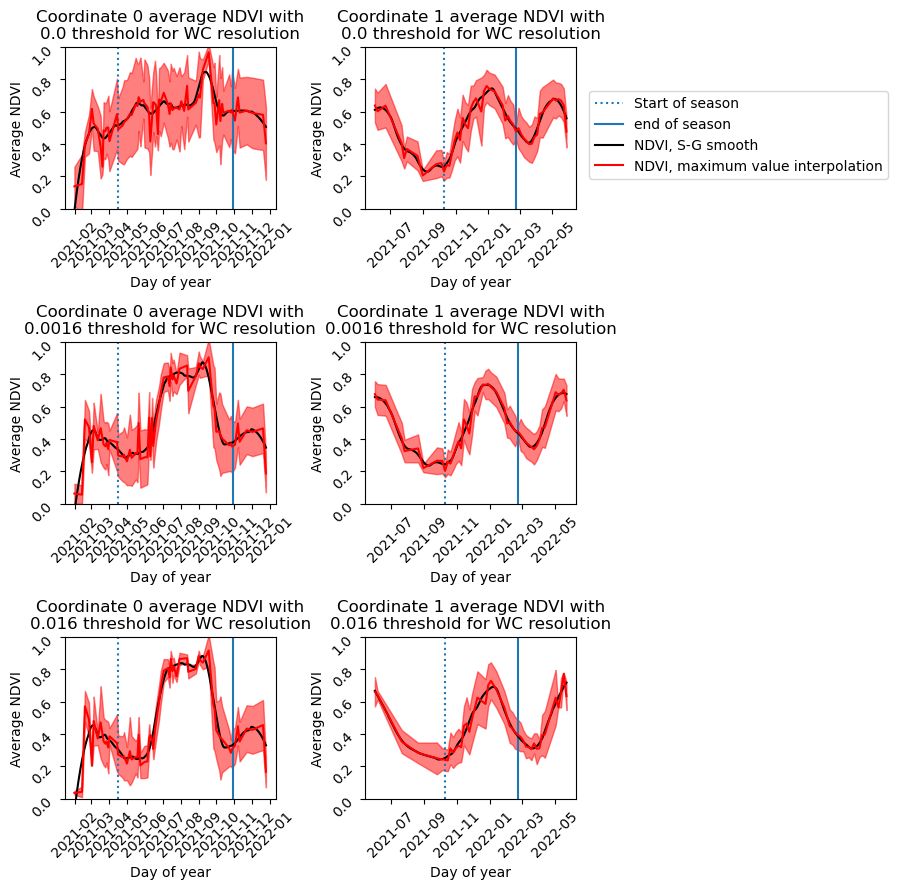

In [84]:
Kenya_coords = dtype =  np.loadtxt(root_directory + "Saved_files/station_coords_Kenya.csv", {'names': ('lat', 'lon', 'region', 'west', 'south', 'east', 'north'),
                     'formats': ('f8', 'f8', 'S20', 'f8', 'f8', 'f8', 'f8')})
DE_coords = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')
coords_to_plot = [DE_coords[6], Kenya_coords[27]]#, Kenya_coords[28]
compare_thresholds_Sentinel2( coords = coords_to_plot,
                             thresholds = [0, 1, 10], mask_scale = 20,#15 sems like a bound
                            interp_method = 'linear')

In [85]:
Kenya_coords[0]

(0.06542651, 34.21713639, b'Alego-Usonga', 34.04420853, -0.04395609, 34.39006424, 0.17480911)

1th coord
threshold 1


/home/users/wlwc1989/earth_engine_MP/data_cleaning.py:43: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  ds.loc[:, ds.columns != 'reducer']  = ds.loc[:, ds.columns != 'reducer'].interpolate()


threshold 2


/home/users/wlwc1989/earth_engine_MP/data_cleaning.py:43: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  ds.loc[:, ds.columns != 'reducer']  = ds.loc[:, ds.columns != 'reducer'].interpolate()


threshold 3


/home/users/wlwc1989/earth_engine_MP/data_cleaning.py:43: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  ds.loc[:, ds.columns != 'reducer']  = ds.loc[:, ds.columns != 'reducer'].interpolate()


2th coord
threshold 1


/home/users/wlwc1989/earth_engine_MP/data_cleaning.py:43: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  ds.loc[:, ds.columns != 'reducer']  = ds.loc[:, ds.columns != 'reducer'].interpolate()


threshold 2


/home/users/wlwc1989/earth_engine_MP/data_cleaning.py:43: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  ds.loc[:, ds.columns != 'reducer']  = ds.loc[:, ds.columns != 'reducer'].interpolate()


threshold 3


/home/users/wlwc1989/earth_engine_MP/data_cleaning.py:43: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  ds.loc[:, ds.columns != 'reducer']  = ds.loc[:, ds.columns != 'reducer'].interpolate()


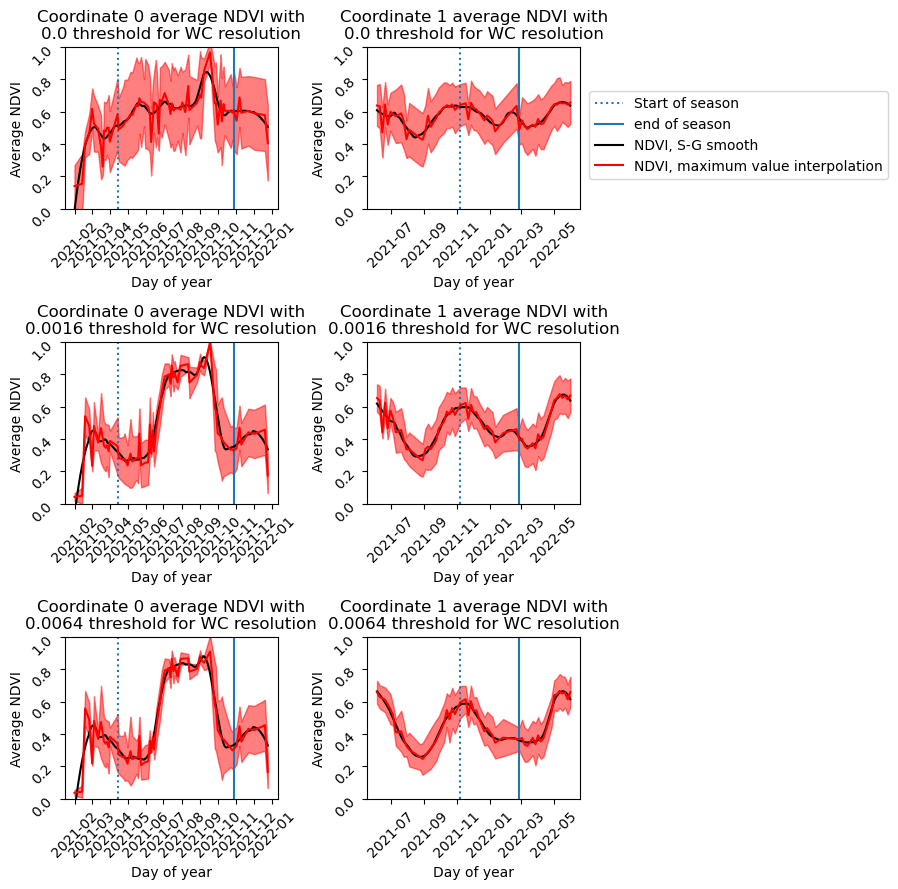

In [74]:
Kenya_coords = dtype =  np.loadtxt(root_directory + "Saved_files/station_coords_Kenya.csv", {'names': ('lat', 'lon', 'region', 'west', 'south', 'east', 'north'),
                     'formats': ('f8', 'f8', 'S20', 'f8', 'f8', 'f8', 'f8')})
DE_coords = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')
coords_to_plot = [DE_coords[6], Kenya_coords[7]]
compare_thresholds_Sentinel2(coords = coords_to_plot,
                             thresholds = [0, 1, 4], mask_scale = 10,
                            interp_method = 'linear')

In [48]:
def compare_veg_indices2(instrument = 'COPERNICUS/S2_SR_HARMONIZED',
                       coords = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')[0:2],
                      country = 'DE', crop_type = 'M', year = 2019, root_directory = '', N=1, reducer_code = 'median',
                      mask_scale=10, buffer_size=3000, bands = ['EVI','NDVI', 'SAVI', 'NDWI', 'CIG']):
    fig, axs = plt.subplots(len(coords), 1, figsize = (10, 15))
    for coord_index, coord in enumerate(coords):
        f1 = ee.Feature(ee.Geometry.Point([coord[1],coord[0]]).buffer(buffer_size),{'ID':'A'})
        f1c = ee.FeatureCollection([f1])
        IC = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED').filterBounds(f1c)
        IC = IC.filterDate(f'{year}-01-01',f'{year}-12-31')
        IC = IC.spectralIndices(['NDVI', 'EVI'])
        IC = csPlus_mask_collection(IC)
        masked = csPlus_mask_collection(IC)
        crop = WC_reduced_in_region(IC, 10, product_codes[crop_type])
        #world_cereals = ee.ImageCollection('ESA/WorldCereal/2021/MODELS/v100').map(mask_other)
        #crop = world_cereals.filter(product_codes[crop_type]).mosaic().select('classification').gt(0)
        #crop = crop.updateMask(crop)
        #crop = crop.setDefaultProjection(world_cereals.first().select('classification').projection(), scale = 10)
        #crop = count_reducer(crop).gt(count_threshold)
        #print(crop.bandNames().getInfo())
        #region = mask_other(crop)#.geometry())#.geometry()
        region = mask_other(crop.clip(f1)).geometry()
        IC = IC.map(lambda img: img.updateMask(crop))
        ts = getTimeSeriesByRegion(IC,
                                   reducer = [ee.Reducer.mean(), ee.Reducer.stdDev()], #ee.Reducer.median(),
                                   geometry = region, 
                                   bands = ['NDVI'], scale = mask_scale)
        x = geemap.ee_to_df(ts)
        for VI_index, veg_index in enumerate(['NDVI']):#bands):
            x['date'] = pd.to_datetime(x['date'])
            x = x.where(x['NDVI']!=-9999).dropna()
            xreduced = x.where(x['reducer'] == reducer_code).dropna()
            colour = ['blue', 'red', 'green', 'black', 'purple'][VI_index]
            line_style = ['solid', 'solid', 'dotted', 'dashed', 'dashdot'][VI_index]
            if coord_index == 0:
                axs[coord_index].plot(xreduced['date'], (xreduced[veg_index]/np.max([1, xreduced[veg_index].max()]))*np.sign( xreduced[veg_index].max()),
                                      c = colour, label = veg_index, linestyle = line_style)
            else:
                axs[coord_index].plot(xreduced['date'], (xreduced[veg_index]/np.max([1, xreduced[veg_index].max()]))*np.sign( xreduced[veg_index].max()),
                                      c = colour, linestyle = line_style)
        axs[coord_index].set_title('Comparing different VIs')
        axs[coord_index].tick_params(labelrotation=45)
        axs[coord_index].set_ylim([0, 1])
    fig.legend()
    fig.tight_layout()

In [ ]:
compare_veg_indices2(reducer_code = 'mean', mask_scale = 20)

In [18]:
def compare_thresholds_Sentinel2(instrument = 'COPERNICUS/S1_GRD',
                            coord = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')[0],
                            country = 'DE', crop_type = 'M', year = 2021, root_directory = '', 
                             N=200, reducer_code = 'mean',
                            mask_scale=10, interp_method = 'MVI',
                           savename = False, count_threshold = 15):
    country_codes = {'DE': 93,
                     'KEN': 133}
    product_codes = {'M': 'product == "maize"',
                     'ww': 'product == "wintercereals"'}
    fig, ax = plt.subplots(3, 2, figsize = (6, 9))
    colour_list = ['blue', 'red', 'green', 'black', 'purple']
    linestyle_list = ['solid', 'solid', 'dotted', 'dashed', 'dashdot']
    for coord_index in range(1):
        dataset = ee.FeatureCollection('FAO/GAUL/2015/level2').filterMetadata('ADM0_NAME','equals','Kenya')
        featList = dataset.toList(999)
        feature_index = [10, 38, 37][coord_index]
        f1 = ee.Feature(ee.List(featList).get(feature_index))#38? 37?
        bundesland = f1.get('ADM2_NAME').getInfo()
        print(bundesland)
        f1c = ee.FeatureCollection([f1])
        IC = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED').filterBounds(f1c)
        IC = IC.filterDate(f'{year}-06-01',f'{year + 1}-06-01')
        IC = IC.spectralIndices(['NDVI', 'EVI'])
        IC = csPlus_mask_collection(IC)
        for threshold_index, count_threshold in enumerate([0, 2, 80]):#[30, 70, 90]):#[500, 600, 700, 800]):
            axs = ax[threshold_index, coord_index]
            if count_threshold == 0:
                ts = getTimeSeriesByRegion(IC,
                                           reducer = [ee.Reducer.mean(),ee.Reducer.median(), ee.Reducer.stdDev()], 
                                           geometry = f1.geometry(), #ee.Geometry.Point([coord[1],coord[0]]).buffer(5000), 
                                           bands = ['NDVI'], scale = mask_scale)
            else:
                crop = WC_reduced_in_region(IC, count_threshold, product_codes[crop_type])
                region = mask_other(crop.clip(f1)).geometry()
                IC = IC.map(lambda img: img.updateMask(crop))
                ts = getTimeSeriesByRegion(IC,
                                           reducer = [ee.Reducer.mean(), ee.Reducer.stdDev()], #ee.Reducer.median(),
                                           geometry = region, 
                                           bands = ['NDVI'], scale = mask_scale)
            try:
                x = geemap.ee_to_df(ts).sort_index(ascending=True)
            except:
                print('region empty')
                continue
            x['date'] = pd.to_datetime(x['date'])
            x = x.where(x['NDVI']!=-9999).dropna()
            xreduced = x.where(x['reducer'] == reducer_code).dropna()
            xstd = x.where(x['reducer'] == 'stdDev').dropna()
            axs.tick_params(labelrotation=45)
            axs.set_xlabel('Day of year')
            axs.set_ylabel('Average NDVI')
            try:
                plot_smoothed_NDVIs(fig, axs, xreduced, xstd, interp_method = interp_method, window_length = 15)
            except:
                print('empty with large threshold')
            #country_name = ['GERMANY', 'KENYA'][coord_index]
            threshold_name = ['no crop mask', 'low threshold', 'high threshold'][threshold_index]
            axs.set_title(f'{bundesland}, {threshold_name}')
            if coord_index == 0:
                EOS = np.datetime64(f'{year}-01-01') + np.timedelta64(int(WC_EOS(coord[1], coord[0])), 'D')
            else:
                EOS = np.datetime64(f'{year + 1}-01-01') + np.timedelta64(int(WC_EOS(coord[1], coord[0])), 'D')
            SOS = np.datetime64(f'{year}-01-01') + np.timedelta64(int(WC_SOS(coord[1], coord[0])), 'D')
            axs.axvline(SOS, linestyle = ':', label='Start of season')
            axs.axvline(EOS, label = 'end of season')
            if coord_index == 0 and threshold_index == 0:
                fig.legend(bbox_to_anchor = [1.5, 0.9])
            #axs.set_title(f'Coordinate {coord_index} average NDVI with\n{count_threshold} threshold for WC resolution')
            #plt.show()
    fig.suptitle('Average NDVI in 10km radius around point with\n(a) no crop mask,\n(b) crop mask with a low threshold aggregation,\n(c) crop mask with a high threshold aggregation')
    fig.tight_layout()

In [19]:
def compare_thresholds_MODIS2(instrument = 'COPERNICUS/S1_GRD',
                            coords = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')[[0, 6, 8, 10]],
                            country = 'DE', crop_type = 'M', year = 2021, root_directory = '', 
                             N=200, reducer_code = 'mean',
                            mask_scale=250, interp_method = 'MVI',
                           savename = False, count_threshold = 15):
    country_codes = {'DE': 93,
                     'KEN': 133}
    product_codes = {'M': 'product == "maize"',
                     'ww': 'product == "wintercereals"'}
    fig, ax = plt.subplots(3, 2, figsize = (6, 9))
    colour_list = ['blue', 'red', 'green', 'black', 'purple']
    linestyle_list = ['solid', 'solid', 'dotted', 'dashed', 'dashdot']
    for coord_index in range(2):
        if coord_index == 0:
            coord = coords[coord_index]
        else:
            coord = coords[1]
        if coord_index == 0:
            dataset = ee.FeatureCollection('FAO/GAUL/2015/level2').filterMetadata('ADM0_NAME','equals','Germany')
            featList = dataset.toList(999)
            f1 = ee.Feature(ee.List(featList).get(0))
            bundesland = f1.get('ADM2_NAME').getInfo()
            print(bundesland)
        else:
            dataset = ee.FeatureCollection('FAO/GAUL/2015/level2').filterMetadata('ADM0_NAME','equals','Kenya')
            featList = dataset.toList(999)
            if coord_index == 1:
                f1 = ee.Feature(ee.List(featList).get(10))#38? 37?
            else:
                f1 = ee.Feature(ee.List(featList).get(38))#38? 37?
            bundesland = f1.get('ADM2_NAME').getInfo()
            print(bundesland)
        f1c = ee.FeatureCollection([f1])
        IC = ee.ImageCollection("MODIS/061/MOD09GQ").filterBounds(f1c)
        if coord_index == 0:
            IC = IC.filterDate(f'{year}-01-01',f'{year}-12-31')
        else:
            IC = IC.filterDate(f'{year}-06-01',f'{year + 1}-06-01')
        IC = MODIS_mask_clouds_250m(IC)
        IC = IC.map(addNDVI)
        for threshold_index, count_threshold in enumerate([0, 2, 80]):#[30, 70, 90]):#[500, 600, 700, 800]):
            axs = ax[threshold_index, coord_index]
            if count_threshold == 0:
                #world_cereals = ee.ImageCollection('ESA/WorldCereal/2021/MODELS/v100').map(mask_other)
                #crop = world_cereals.filter(crop_type_code).mosaic().select('classification').gt(0)
                #crop = crop.updateMask(crop)
                ts = getTimeSeriesByRegion(IC,
                                           reducer = [ee.Reducer.mean(),ee.Reducer.median(), ee.Reducer.stdDev()], 
                                           geometry = f1.geometry(), #ee.Geometry.Point([coord[1],coord[0]]).buffer(5000), 
                                           bands = ['NDVI'], scale = mask_scale)
            #elif coord_index == 2:
            #    continue
            else:
                crop = WC_reduced_in_region(IC, count_threshold, product_codes[crop_type])
                region = mask_other(crop.clip(f1)).geometry()
                IC = IC.map(lambda img: img.updateMask(crop))
                ts = getTimeSeriesByRegion(IC,
                                           reducer = [ee.Reducer.mean(), ee.Reducer.stdDev()], #ee.Reducer.median(),
                                           geometry = region, 
                                           bands = ['NDVI'], scale = mask_scale)
            try:
                x = geemap.ee_to_df(ts).sort_index(ascending=True)
            except:
                print('region empty')
                continue
            x['date'] = pd.to_datetime(x['date'])
            x = x.where(x['NDVI']!=-9999).dropna()
            xreduced = x.where(x['reducer'] == reducer_code).dropna()
            xstd = x.where(x['reducer'] == 'stdDev').dropna()
            axs.tick_params(labelrotation=45)
            axs.set_xlabel('Day of year')
            axs.set_ylabel('Average NDVI')
            try:
                plot_smoothed_NDVIs(fig, axs, xreduced, xstd, interp_method = interp_method, window_length = 15)
            except:
                print('empty with large threshold')
            #country_name = ['GERMANY', 'KENYA'][coord_index]
            threshold_name = ['no crop mask', 'low threshold', 'high threshold'][threshold_index]
            axs.set_title(f'{bundesland}, {threshold_name}')
            if coord_index == 0:
                EOS = np.datetime64(f'{year}-01-01') + np.timedelta64(int(WC_EOS(coord[1], coord[0])), 'D')
            else:
                EOS = np.datetime64(f'{year + 1}-01-01') + np.timedelta64(int(WC_EOS(coord[1], coord[0])), 'D')
            SOS = np.datetime64(f'{year}-01-01') + np.timedelta64(int(WC_SOS(coord[1], coord[0])), 'D')
            axs.axvline(SOS, linestyle = ':', label='Start of season')
            axs.axvline(EOS, label = 'end of season')
            if coord_index == 0 and threshold_index == 0:
                fig.legend(bbox_to_anchor = [1.5, 0.9])
            #axs.set_title(f'Coordinate {coord_index} average NDVI with\n{count_threshold} threshold for WC resolution')
            #plt.show()
    fig.suptitle('Average NDVI in 10km radius around point with\n(a) no crop mask,\n(b) crop mask with a low threshold aggregation,\n(c) crop mask with a high threshold aggregation')
    fig.tight_layout()

Freiburg
Mbeere


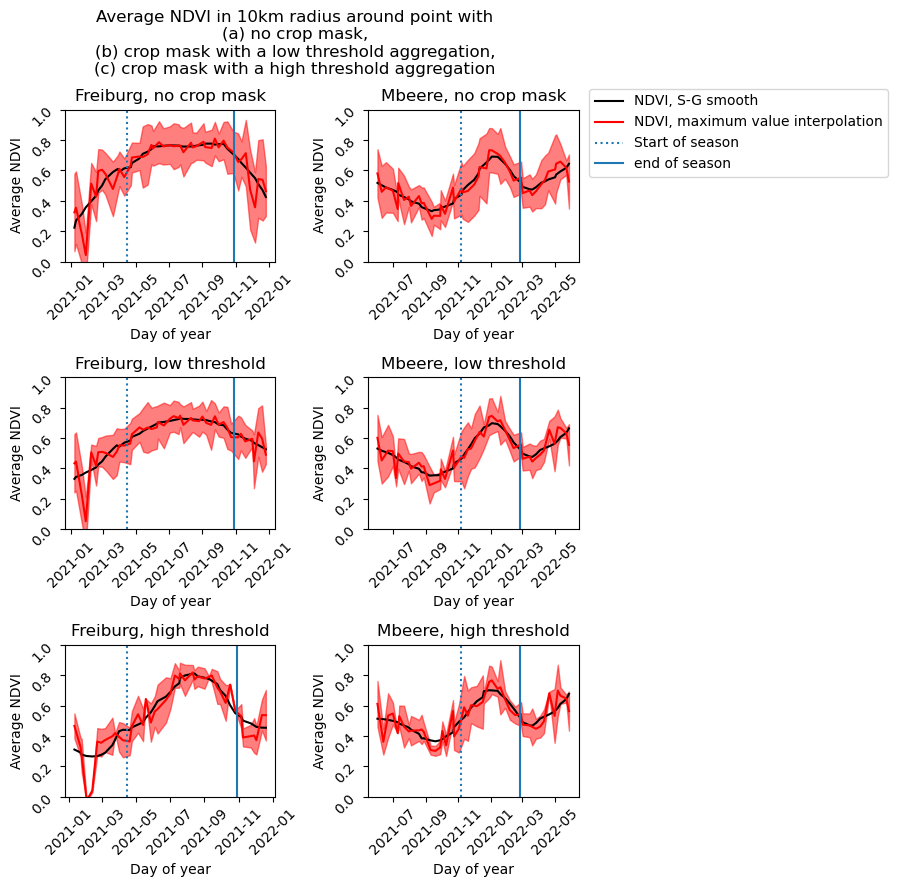

In [98]:
Kenya_coords = dtype =  np.loadtxt(root_directory + "Saved_files/station_coords_Kenya.csv", {'names': ('lat', 'lon', 'region', 'west', 'south', 'east', 'north'),
                     'formats': ('f8', 'f8', 'S20', 'f8', 'f8', 'f8', 'f8')})
DE_coords = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')
coords_to_plot = [DE_coords[6], Kenya_coords[7]]
compare_thresholds_MODIS2(coords = coords_to_plot)

In [92]:
def compare_thresholds_MODIS(instrument = 'COPERNICUS/S1_GRD',
                            coords = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')[[0, 6, 8, 9]],
                            country = 'DE', crop_type = 'M', year = 2021, root_directory = '', 
                             N=200, reducer_code = 'mean',
                            mask_scale=250, interp_method = 'MVI',
                           savename = False, count_threshold = 15,
                            thresholds = [30, 400, 700]):
    country_codes = {'DE': 93,
                     'KEN': 133}
    product_codes = {'M': 'product == "maize"',
                     'ww': 'product == "wintercereals"'}
    fig, ax = plt.subplots(len(thresholds), len(coords), figsize = (3*len(coords), 12))
    for coord_index, coord in enumerate(coords):
        print(f'{coord_index + 1}th coord')
        grid_cell_lon = coord[1]
        grid_cell_lat = coord[0]
        f1 = ee.Feature(ee.Geometry.Point([coord[1],coord[0]]).buffer(5000),{'ID':'A'})
        f1c = ee.FeatureCollection([f1])
        IC = (ee.ImageCollection("MODIS/061/MOD09GQ")
             .filterBounds(f1c)
             .filterDate(f'{year}-01-01',f'{year}-12-31'))
        IC = MODIS_mask_clouds_250m(IC)
        IC = IC.map(addNDVI)
        for threshold_index, count_threshold in enumerate(thresholds):
            print(f'Threshold {count_threshold}')
            axs = ax[threshold_index, coord_index]
            crop = WC_reduced_in_region(IC, count_threshold, product_codes[crop_type])
            region = mask_other(crop.clip(f1)).geometry()
            IC = IC.map(lambda img: img.updateMask(crop))
            ts = getTimeSeriesByRegion(IC,
                                       reducer = [ee.Reducer.mean(),ee.Reducer.median(), ee.Reducer.stdDev()], 
                                       geometry = region, 
                                       bands = ['NDVI'], scale = mask_scale)
            try:
                x = geemap.ee_to_df(ts).sort_index(ascending=True)
            except:
                print('region empty')
                continue
            x['date'] = pd.to_datetime(x['date'])
            x = x.where(x['NDVI']!=-9999).dropna()
            xreduced = x.where(x['reducer'] == reducer_code).dropna()
            xstd = x.where(x['reducer'] == 'stdDev').dropna()
            axs.tick_params(labelrotation=45)
            axs.set_xlabel('Day of year')
            axs.set_ylabel('Average NDVI')
            plot_smoothed_NDVIs(fig, axs, xreduced, xstd, interp_method = interp_method, window_length = 20)
            axs.set_title(f'Coordinate {coord_index} average NDVI with\n{count_threshold/625} threshold for WC resolution')
    fig.tight_layout()

1th coord
Threshold 700
Threshold 800
2th coord
Threshold 700
Threshold 800
3th coord
Threshold 700
Threshold 800
4th coord
Threshold 700
Threshold 800


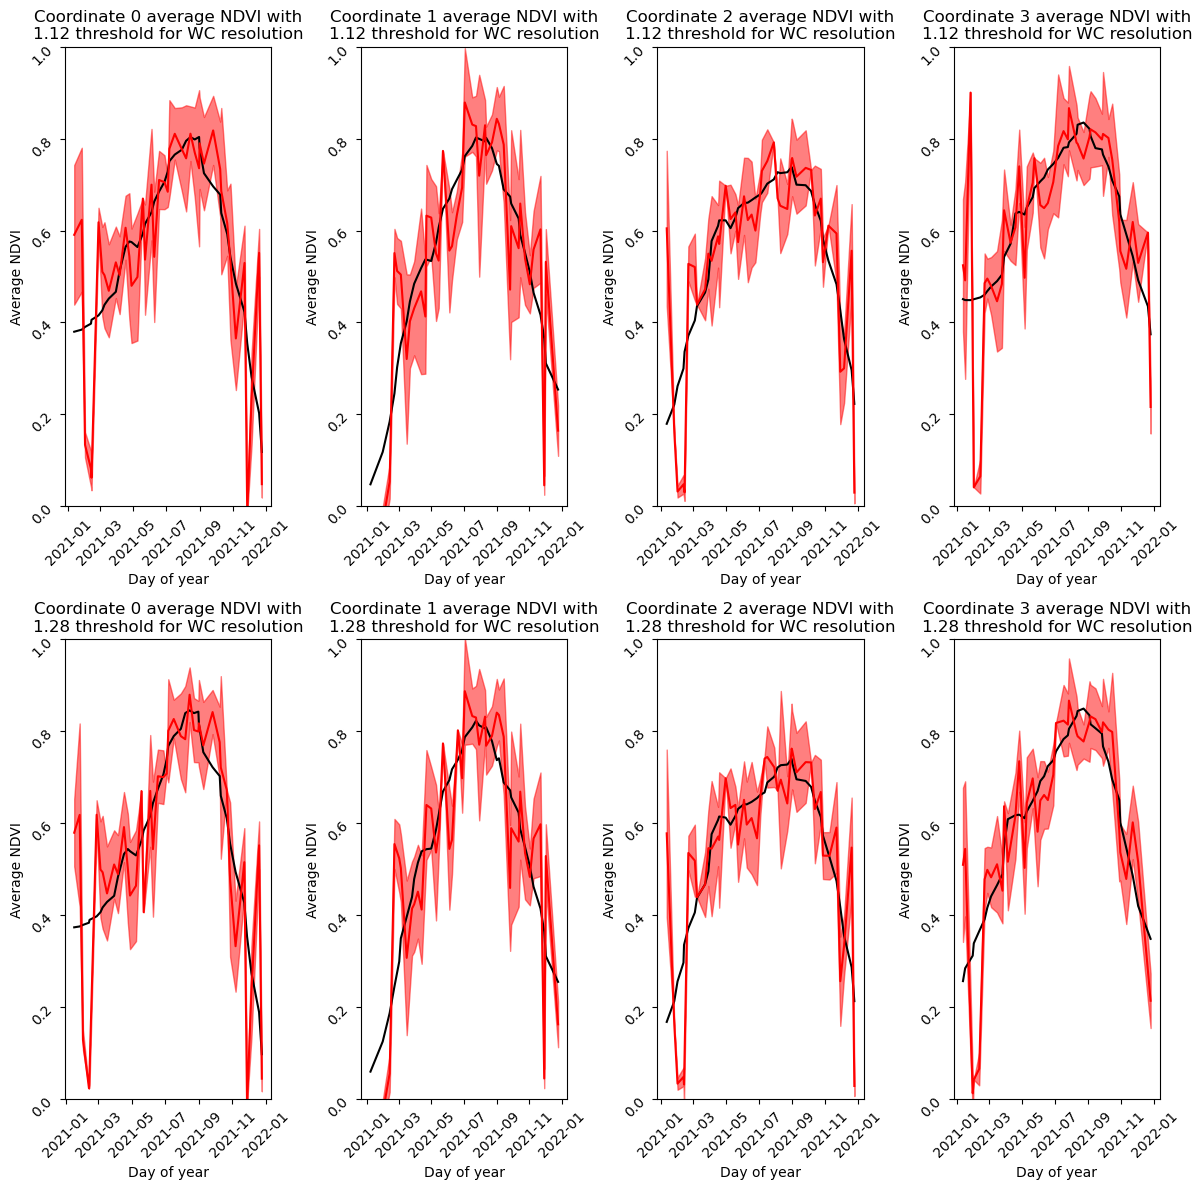

In [94]:
compare_thresholds_MODIS(coords = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')[[0, 6, 8, 9]],
                        thresholds = [700, 800])

In [30]:
def compare_buffers_MODIS(instrument = 'COPERNICUS/S1_GRD',
                            coords = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')[[0, 6, 8, 9]],
                            country = 'DE', crop_type = 'M', year = 2019, root_directory = '', N=200, reducer_code = 'mean',
                            mask_scale=250, interp_method = 'MVI',
                           savename = False, count_threshold = 15):
    country_codes = {'DE': 93,
                     'KEN': 133}
    product_codes = {'M': 'product == "maize"',
                     'ww': 'product == "wintercereals"'}
    fig, ax = plt.subplots(4, len(coords), figsize = (3*len(coords), 12))
    colour_list = ['blue', 'red', 'green', 'black', 'purple']
    linestyle_list = ['solid', 'solid', 'dotted', 'dashed', 'dashdot']
    for coord_index, coord in enumerate(coords):
        print(f'{coord_index + 1}th coord')
        grid_cell_lon = coord[1]
        grid_cell_lat = coord[0]
        f1 = ee.Feature(ee.Geometry.Point([coord[1],coord[0]]).buffer(10000),{'ID':'A'})
        f1c = ee.FeatureCollection([f1])
        IC = (ee.ImageCollection("MODIS/061/MOD09GQ")
             .filterBounds(f1c)
             .filterDate(f'{year}-01-01',f'{year}-12-31'))
        IC = MODIS_mask_clouds_250m(IC)
        IC = IC.map(addNDVI)
        world_cereals = ee.ImageCollection('ESA/WorldCereal/2021/MODELS/v100').map(mask_other)
        crop = world_cereals.filter(product_codes[crop_type]).mosaic().select('classification').gt(0)
        region = mask_other(crop.clip(f1)).geometry()
        for buffer_index, buffer_size in enumerate([50, 100, 150, 250]):
            axs = ax[buffer_index, coord_index]
            vectors = crop.reduceToVectors(**{
                'geometry': region,
                'scale': 10,
                'maxPixels': 1e13,
                'bestEffort':True,
                'eightConnected': False,
                })
            vectors = vectors.map(lambda feat: feat.buffer(-buffer_size))
            random_points = ee.FeatureCollection.randomPoints(**{'region': vectors, 'points': N, 'seed': 46, 'maxError': 1})#
            ts = getTimeSeriesByRegion(IC,
                                       reducer = [ee.Reducer.mean(),ee.Reducer.median(), ee.Reducer.stdDev()], 
                                       geometry = random_points, 
                                       bands = ['NDVI'], scale = mask_scale)
            try:
                x = geemap.ee_to_df(ts).sort_index(ascending=True)
            except:
                print('region empty')
                continue
            x['date'] = pd.to_datetime(x['date'])
            x = x.where(x['NDVI']!=-9999).dropna()
            xreduced = x.where(x['reducer'] == reducer_code).dropna()
            xstd = x.where(x['reducer'] == 'stdDev').dropna()
            axs.tick_params(labelrotation=45)
            axs.set_xlabel('Day of year')
            axs.set_ylabel('Average NDVI')
            plot_smoothed_NDVIs(fig, axs, xreduced, xstd, interp_method = interp_method, window_length = 20)
            axs.set_title(f'Coordinate {coord_index} average NDVI with\n{buffer_size}m field buffer')

1th coord


/home/users/wlwc1989/earth_engine_MP/data_cleaning.py:10: FutureWarning: The behavior of Series.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  return df.loc[[df['NDVI'].idxmax()]]


issue with standard deviations
region empty
region empty
2th coord
region empty
3th coord
region empty
region empty
4th coord
region empty


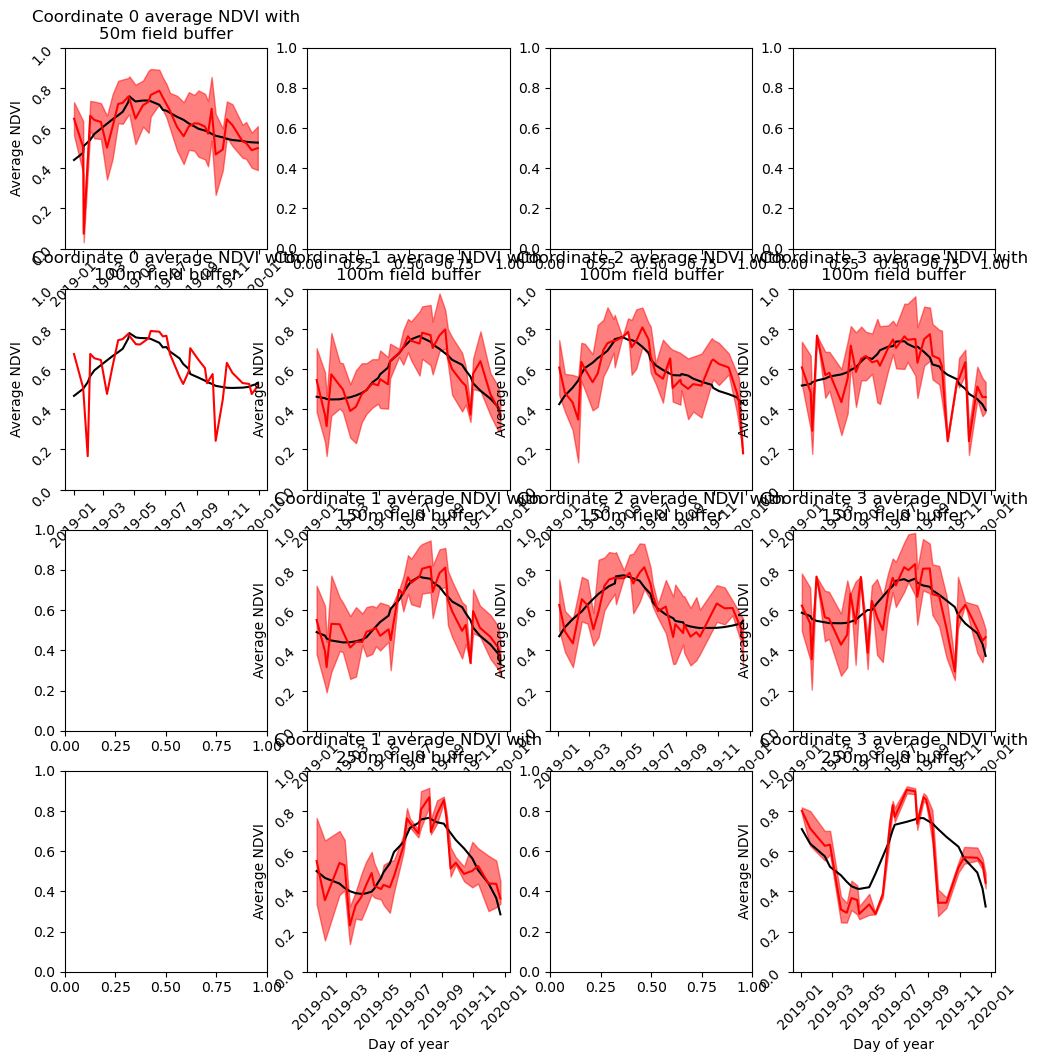

In [31]:
compare_buffers_MODIS(coords = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')[[0, 6, 8, 9]])

In [7]:
def compare_averaging_width_MODIS2(instrument = 'COPERNICUS/S1_GRD',
                            coords = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')[[0, 6, 8, 9]],
                            country = 'DE', crop_type = 'M', year = 2019, root_directory = '', N=200, reducer_code = 'mean',
                            mask_scale=250,  widths = range(2000, 20000, 5000),
                           savename = False, count_threshold = 15):
    country_codes = {'DE': 93,
                     'KEN': 133}
    product_codes = {'M': 'product == "maize"',
                     'ww': 'product == "wintercereals"'}
    fig, axs = plt.subplots(1, len(coords), figsize = (3*len(coords), 3))
    colour_list = ['blue', 'red', 'green', 'black', 'purple']
    linestyle_list = ['solid', 'solid', 'dotted', 'dashed', 'dashdot']
    for coord_index, coord in enumerate(coords):
        print(f'{coord_index + 1}th coord')
        for buffer_size in widths:
            print(f'Buffer size {buffer_size}')
            grid_cell_lon = coord[1]
            grid_cell_lat = coord[0]
            f1 = ee.Feature(ee.Geometry.Point([coord[1],coord[0]]).buffer(buffer_size),{'ID':'A'})
            f1c = ee.FeatureCollection([f1])
            IC = (ee.ImageCollection("MODIS/061/MOD09GQ")
                 .filterBounds(f1c)
                 .filterDate(f'{year}-01-01',f'{year}-12-31'))
            IC = MODIS_mask_clouds_250m(IC)
            world_cereals = ee.ImageCollection('ESA/WorldCereal/2021/MODELS/v100').map(mask_other)
            crop = world_cereals.filter(product_codes[crop_type]).mosaic().select('classification').gt(0)
            crop = crop.updateMask(crop)
            crop = crop.setDefaultProjection(world_cereals.first().select('classification').projection(), scale = 10)
            crop = count_reducer(crop).gt(count_threshold)
            #print(crop.bandNames().getInfo())
            region = mask_other(crop.clip(f1))#.geometry())#.geometry()
            IC = IC.map(lambda img: img.updateMask(region))
            IC = IC.map(addNDVI)
            ts = getTimeSeriesByRegion(IC, 
                                       reducer = [ee.Reducer.mean(),ee.Reducer.median(), ee.Reducer.max()], 
                                       geometry = ee.Geometry.Point([coord[1],coord[0]]).buffer(buffer_size), 
                                       bands = ['NDVI'], scale = mask_scale)
            x = geemap.ee_to_df(ts).sort_index(ascending=True)
            x['date'] = pd.to_datetime(x['date'])
            x = x.sort_values(by='date')
            x = x.where(x['NDVI']!=-9999).dropna()
            xreduced = x.where(x['reducer'] == reducer_code).dropna()
            plot_smoothed_NDVIs(fig, axs[coord_index], xreduced)
            lat = coord[0]
            lon = coord[1]
            axs[coord_index].set_title(f'lat: {lat}, lon: {lon}')
            #axs[coord_index, 0].plot(xreduced['date'], xreduced['NDVI'], 
            #                         label = f'buffer size {buffer_size}m', alpha = 0.5)
            #axs[coord_index, 0].set_title(f'coordinate {coord_index + 1},\nRVI (SAR)')
            #axs[coord_index, 1].set_title(f'coordinate {coord_index + 1},\nNDVI')
            #axs[coord_index, 0].tick_params(labelrotation=45)
            #axs[coord_index, 1].tick_params(labelrotation=45)
            #axs[coord_index, 1].set_ylim([0, 1])    
    
    fig.legend()
    fig.tight_layout(w_pad = 3)
    if savename != False:
        fig.savefig(savename)

In [8]:
def plot_smoothed_NDVIs(fig, ax, ds, interp_method = 'MVI', polyorder = 2, window_length = 30):
    try:
        ds = ds.reset_index()
    except:
        print('Already reset index')
    if interp_method == 'linear':
        ds_interpolated = resample_linear(ds)
    elif interp_method == 'MVI':
        ds_interpolated = data_cleaning.max_value_int(ds, window_size=6) #data_cleaning.
    ax.plot(ds_interpolated['date'], scipy.signal.savgol_filter(ds_interpolated['NDVI'], window_length=window_length, polyorder=polyorder, deriv = 0), label = 'NDVI, S-G smooth', color = 'black')
    #ax.plot(ds_interpolated['date'], ds_interpolated['NDVI'], label = 'NDVI, linear interpolation', color = 'red')
    ax.set_ylim(0, 1)

1th coord
Buffer size 2000
Buffer size 4000
2th coord
Buffer size 2000
Buffer size 4000
3th coord
Buffer size 2000
Buffer size 4000
4th coord
Buffer size 2000
Buffer size 4000


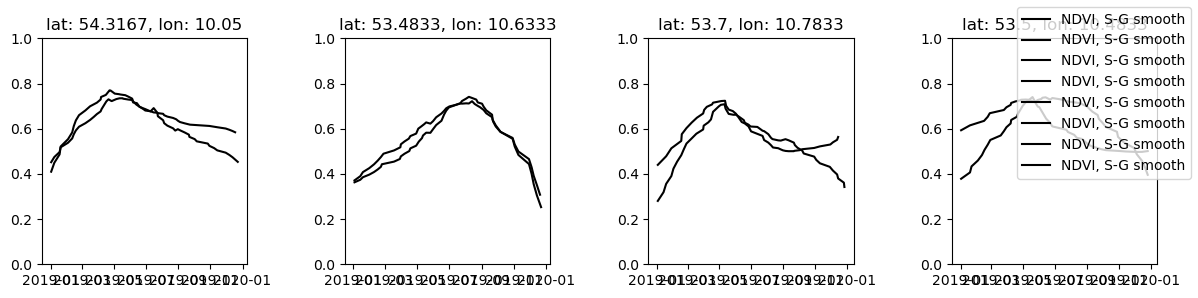

In [42]:
compare_averaging_width_MODIS2(widths = [2000, 4000], count_threshold = 20)

1th coord
Buffer size 2000
Buffer size 4000
2th coord
Buffer size 2000
Buffer size 4000
3th coord
Buffer size 2000
Buffer size 4000
4th coord
Buffer size 2000
Buffer size 4000
5th coord
Buffer size 2000
Buffer size 4000
6th coord
Buffer size 2000
Buffer size 4000
7th coord
Buffer size 2000
Buffer size 4000


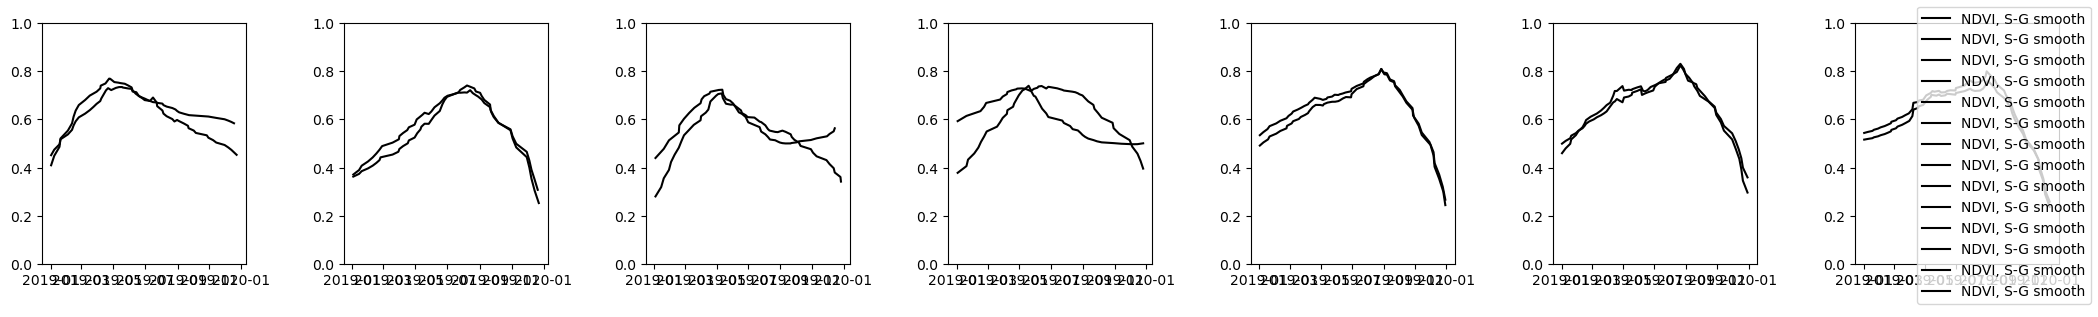

In [36]:
compare_averaging_width_MODIS2(widths = [2000, 4000], count_threshold = 20)

In [9]:
def compare_averaging_width_MODIS(instrument = 'COPERNICUS/S1_GRD',
                            coords = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')[[0, 6, 8]],
                            country = 'DE', crop_type = 'M', year = 2019, root_directory = '', N=200, reducer_code = 'mean',
                            mask_scale=10, MODIS_bands = ['sur_refl_b01','sur_refl_b02'], img_index = 0, widths = range(2000, 20000, 5000),
                           savename = False, indices = False):
    fig, axs = plt.subplots(len(coords), 2, figsize = (10, 15))
    colour_list = ['blue', 'red', 'green', 'black', 'purple']
    linestyle_list = ['solid', 'solid', 'dotted', 'dashed', 'dashdot']
    for coord_index, coord in enumerate(coords):
        print(f'{coord_index + 1}th coord')
        for buffer_size in widths:
            IC, vectors = initialise_comparison(instrument = instrument, coord = coord, 
                                            country = country, crop_type = crop_type, 
                                            year = year, root_directory = root_directory,
                                           mask_scale=mask_scale, buffer_size=buffer_size,
                                           spectral_indices = MODIS_bands, indices = indices)
            random_points = ee.FeatureCollection.randomPoints(**{'region': vectors, 'points': N, 'seed': 46, 'maxError': 1})#
            masked = MODIS_mask_clouds_250m(IC)
            ts = getTimeSeriesByRegion(masked, 
                                       reducer = [ee.Reducer.mean(),ee.Reducer.median(), ee.Reducer.max()], 
                                       geometry = random_points, 
                                       bands = MODIS_bands, scale = mask_scale)
            x = geemap.ee_to_df(ts).sort_index(ascending=True)
            x['date'] = pd.to_datetime(x['date'])
            x = x.sort_values(by='date')
            x['NDVI'] = (x['sur_refl_b02'] - x['sur_refl_b01'])/(x['sur_refl_b02'] + x['sur_refl_b01'])
            x = x.where(x[MODIS_bands[0]]!=-9999).dropna()
            xreduced = x.where(x['reducer'] == reducer_code).dropna()
            axs[coord_index, 0].plot(xreduced['date'], (xreduced['NDVI']/np.max([1, np.abs(xreduced['NDVI']).max()]))*np.sign(xreduced['NDVI'].max()), 
                                     label = f'buffer size {buffer_size}m', alpha = 0.5)        
            print('Now compare to sentinel 2')
            IC_VIS, vectors = initialise_comparison(instrument = 'COPERNICUS/S2_SR_HARMONIZED', coord = coord, 
                                                    country = country, crop_type = crop_type, 
                                                    year = year, root_directory = root_directory,
                                                    mask_scale=mask_scale, buffer_size=buffer_size,
                                                    indices = True)
            
            masked = csPlus_mask_collection(IC_VIS)
            ts = getTimeSeriesByRegion(masked, 
                                       reducer = [ee.Reducer.mean(),ee.Reducer.median(), ee.Reducer.max()], 
                                       geometry = random_points, 
                                       bands = ['NDVI'], scale = mask_scale)
            x = geemap.ee_to_df(ts)
            x['date'] = pd.to_datetime(x['date'])
            x = x.sort_values(by='date')
            x = x.where(x['NDVI']!=-9999).dropna()
            xreduced = x.where(x['reducer'] == reducer_code).dropna()
            axs[coord_index, 1].plot(xreduced['date'], (xreduced['NDVI']), 
                                     alpha = 0.5)
            axs[coord_index, 0].set_title(f'coordinate {coord_index + 1},\nRVI (SAR)')
            axs[coord_index, 1].set_title(f'coordinate {coord_index + 1},\nNDVI')
            axs[coord_index, 0].tick_params(labelrotation=45)
            axs[coord_index, 1].tick_params(labelrotation=45)
            axs[coord_index, 1].set_ylim([0, 1])    
    
    fig.legend()
    fig.tight_layout(w_pad = 3)
    if savename != False:
        fig.savefig(savename)

In [10]:
def compare_sample_sizes_MODIS(instrument = 'COPERNICUS/S2_SR_HARMONIZED',
                     coords = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')[0:2],
                     country = 'DE', crop_type = 'M', year = 2019, root_directory = '',
                     reducer_code = 'median', MODIS_bands = ['sur_refl_b01','sur_refl_b02'],
                              mask_scale= 500, buffer_size = 3000, indices = False):
    fig, ax = plt.subplots(len(coords), 1, figsize = (10, 5))
    for coord_index, coord in enumerate(coords):
        print(f'Coordinate {coord_index + 1}')
        IC, vectors = initialise_comparison(instrument = instrument, coord = coord, 
                                            country = country, crop_type = crop_type, 
                                            year = year, root_directory = root_directory,
                                           mask_scale=mask_scale, buffer_size=buffer_size,
                                           spectral_indices = MODIS_bands, indices = indices)
        for N in range(1, 50, 10):
            masked = MODIS_mask_clouds_250m(IC)
            random_points = ee.FeatureCollection.randomPoints(**{'region': vectors, 
                                                                 'points': N, 'seed': 43, 
                                                                 'maxError': 1})#
            ts = getTimeSeriesByRegion(masked,
                reducer = [ee.Reducer.mean(),ee.Reducer.median(), ee.Reducer.max()],
                geometry = random_points,
                bands = MODIS_bands,#['EVI','NDVI'],#['B4','B8'],
                scale = mask_scale)
            x = geemap.ee_to_df(ts)
            x['date'] = pd.to_datetime(x['date'])
            x['NDVI'] = (x['sur_refl_b02'] - x['sur_refl_b01'])/(x['sur_refl_b02'] + x['sur_refl_b01'])
            x = x.where(x['sur_refl_b01']!=-9999).dropna()
            xreduced = x.where(x['reducer'] == reducer_code).dropna()
            ax[coord_index].scatter(xreduced['date'], xreduced['NDVI'], label = f'Average over {N} samples')
        if coord_index == 0:
            fig.legend()

Coordinate 1
Coordinate 2


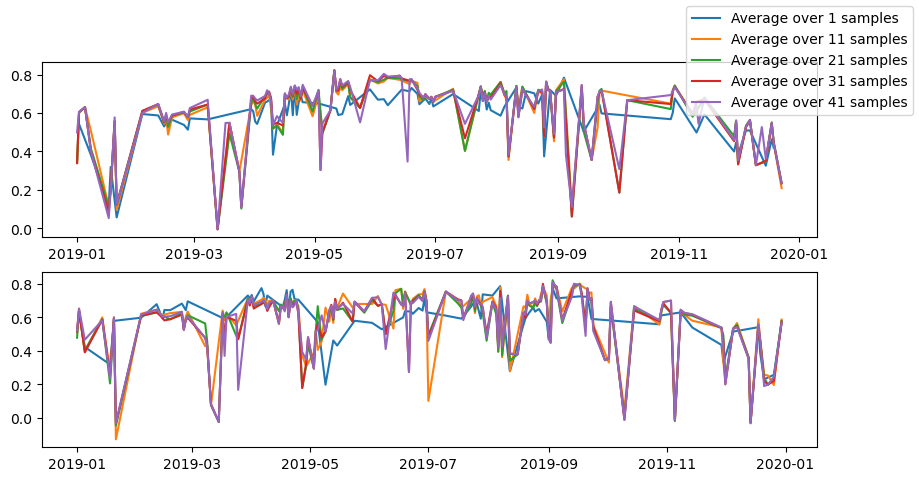

In [15]:
compare_sample_sizes_MODIS(instrument = "MODIS/061/MOD09GQ",#MODIS/006/MOD09GQ
                    reducer_code = 'median', mask_scale = 500, crop_type = 'M')#,

1th coord
Now compare to sentinel 2
Now compare to sentinel 2
Now compare to sentinel 2
Now compare to sentinel 2
2th coord
Now compare to sentinel 2
Now compare to sentinel 2
Now compare to sentinel 2
Now compare to sentinel 2
3th coord
Now compare to sentinel 2
Now compare to sentinel 2
Now compare to sentinel 2
Now compare to sentinel 2


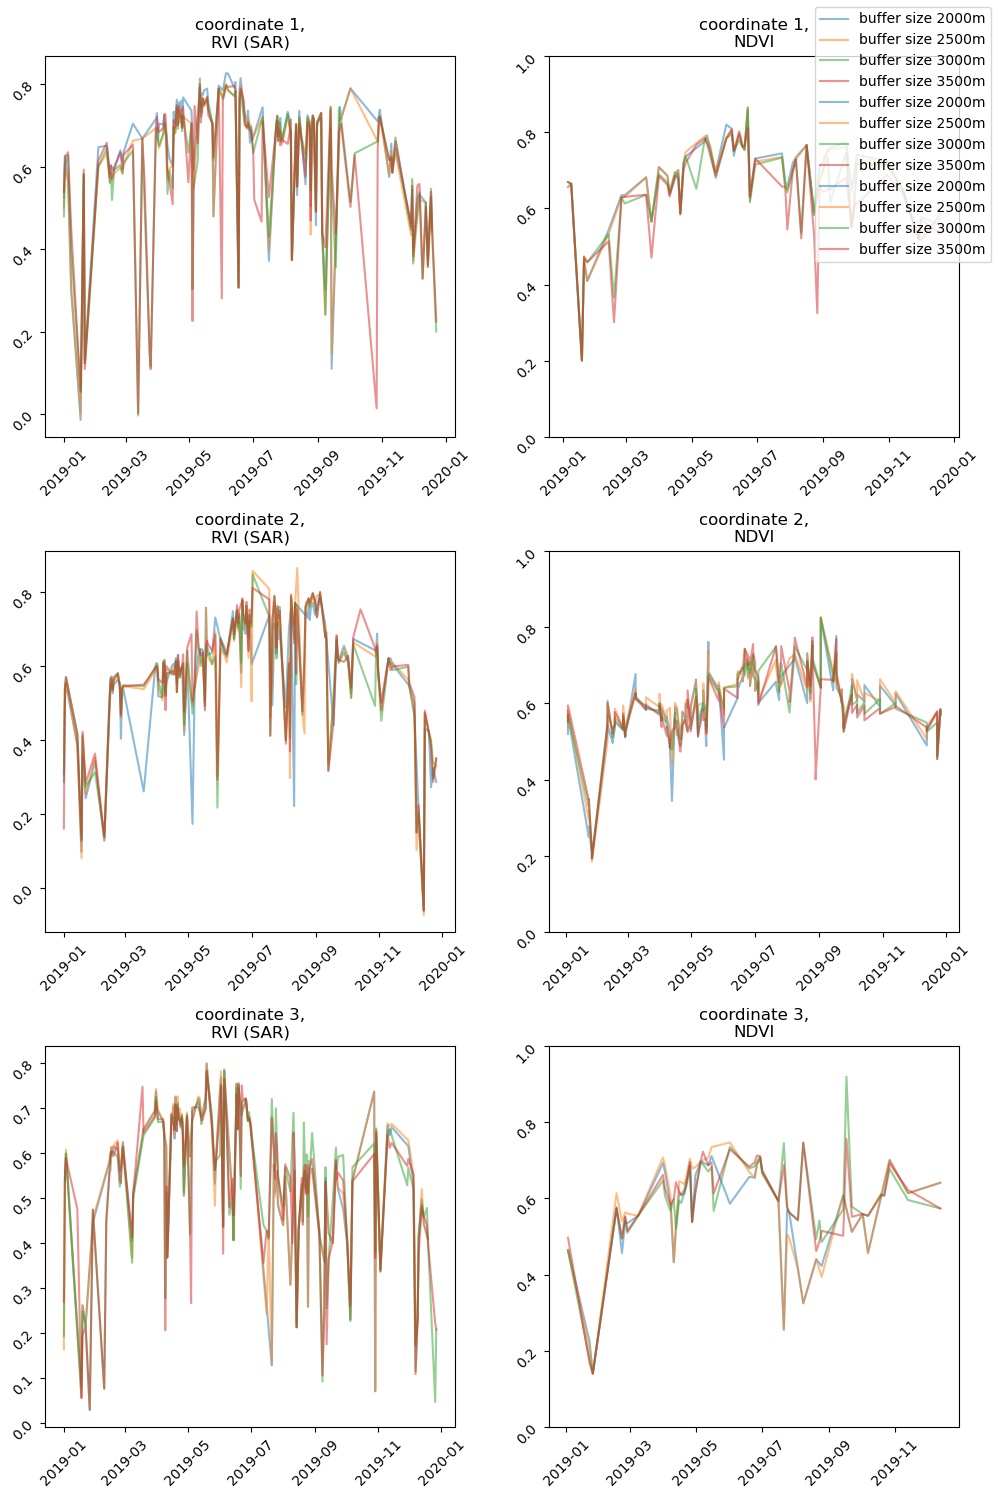

In [19]:
compare_averaging_width_MODIS(instrument = "MODIS/061/MOD09GQ",#MODIS/006/MOD09GQ
                    reducer_code = 'median', mask_scale = 500, crop_type = 'M',
                             widths = range(2000, 4000, 500))#,
                   #bands = ['sur_refl_b01','sur_refl_b02'])

1th coord
First download raw VV and VH
Now compare to VIS
First download raw VV and VH
Now compare to VIS
First download raw VV and VH
Now compare to VIS
First download raw VV and VH
Now compare to VIS
2th coord
First download raw VV and VH
Now compare to VIS
First download raw VV and VH
Now compare to VIS
First download raw VV and VH
Now compare to VIS
First download raw VV and VH
Now compare to VIS
3th coord
First download raw VV and VH
Now compare to VIS
First download raw VV and VH
Now compare to VIS
First download raw VV and VH
Now compare to VIS
First download raw VV and VH
Now compare to VIS


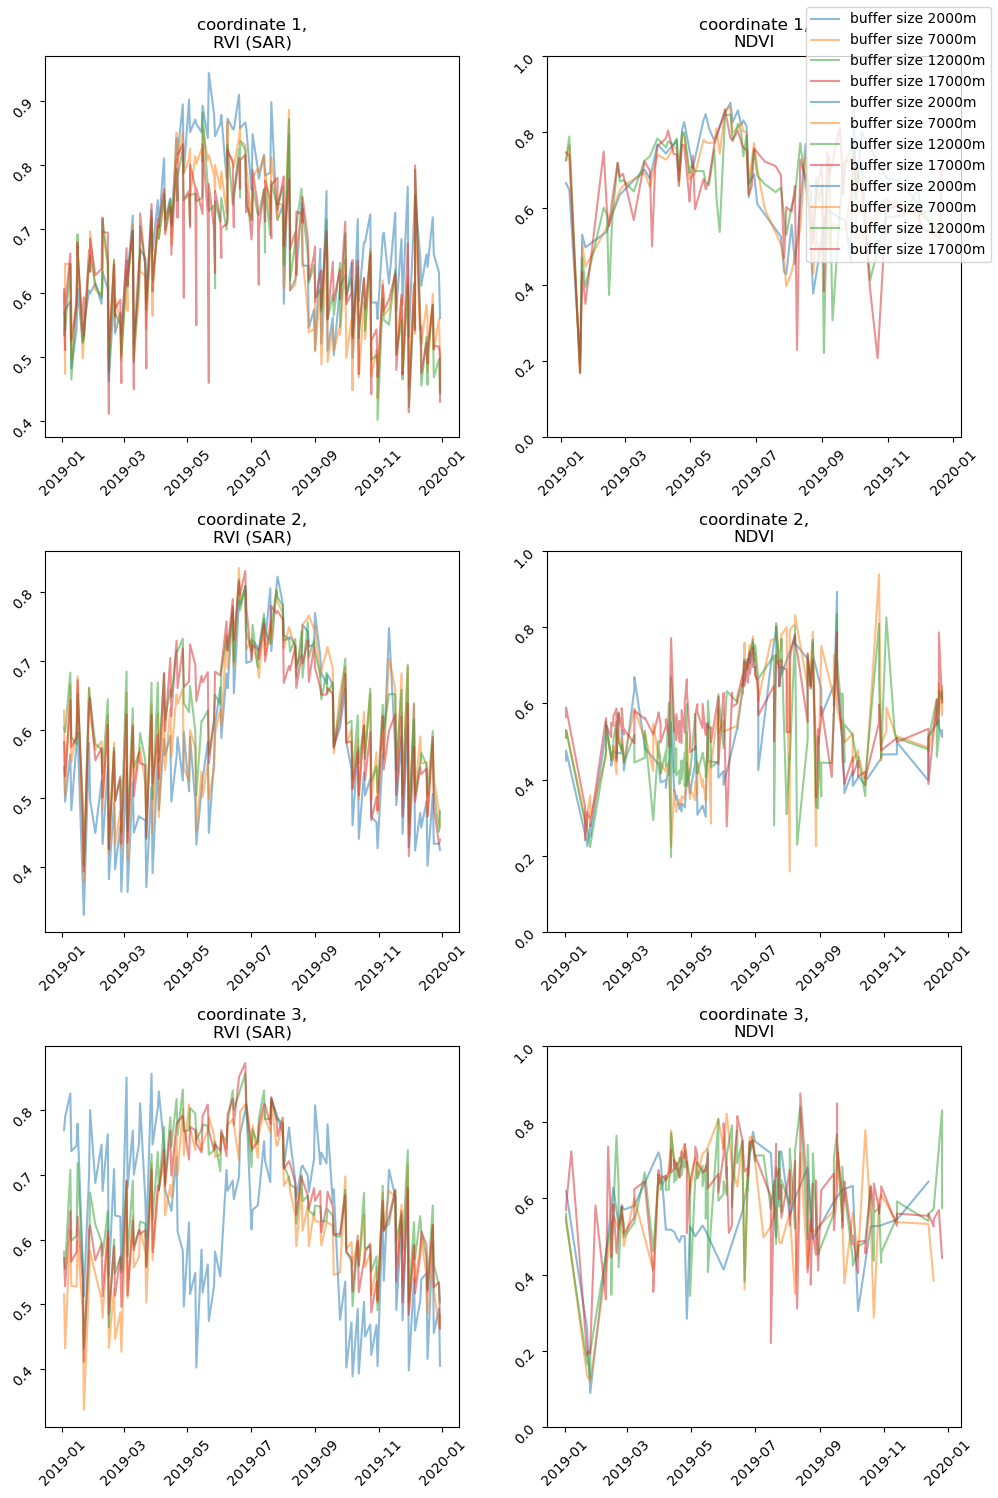

In [16]:
compare_averaging_width(reducer_code = 'median', savename = 'Plots/buffer_sizes_averaging.png', mask_scale = 100)

1th coord
First download raw VV and VH
Now compare to VIS
First download raw VV and VH
Now compare to VIS
First download raw VV and VH
Now compare to VIS
First download raw VV and VH
Now compare to VIS
2th coord
First download raw VV and VH
Now compare to VIS
First download raw VV and VH
Now compare to VIS
First download raw VV and VH
Now compare to VIS
First download raw VV and VH
Now compare to VIS
3th coord
First download raw VV and VH
Now compare to VIS
First download raw VV and VH
Now compare to VIS
First download raw VV and VH
Now compare to VIS
First download raw VV and VH
Now compare to VIS


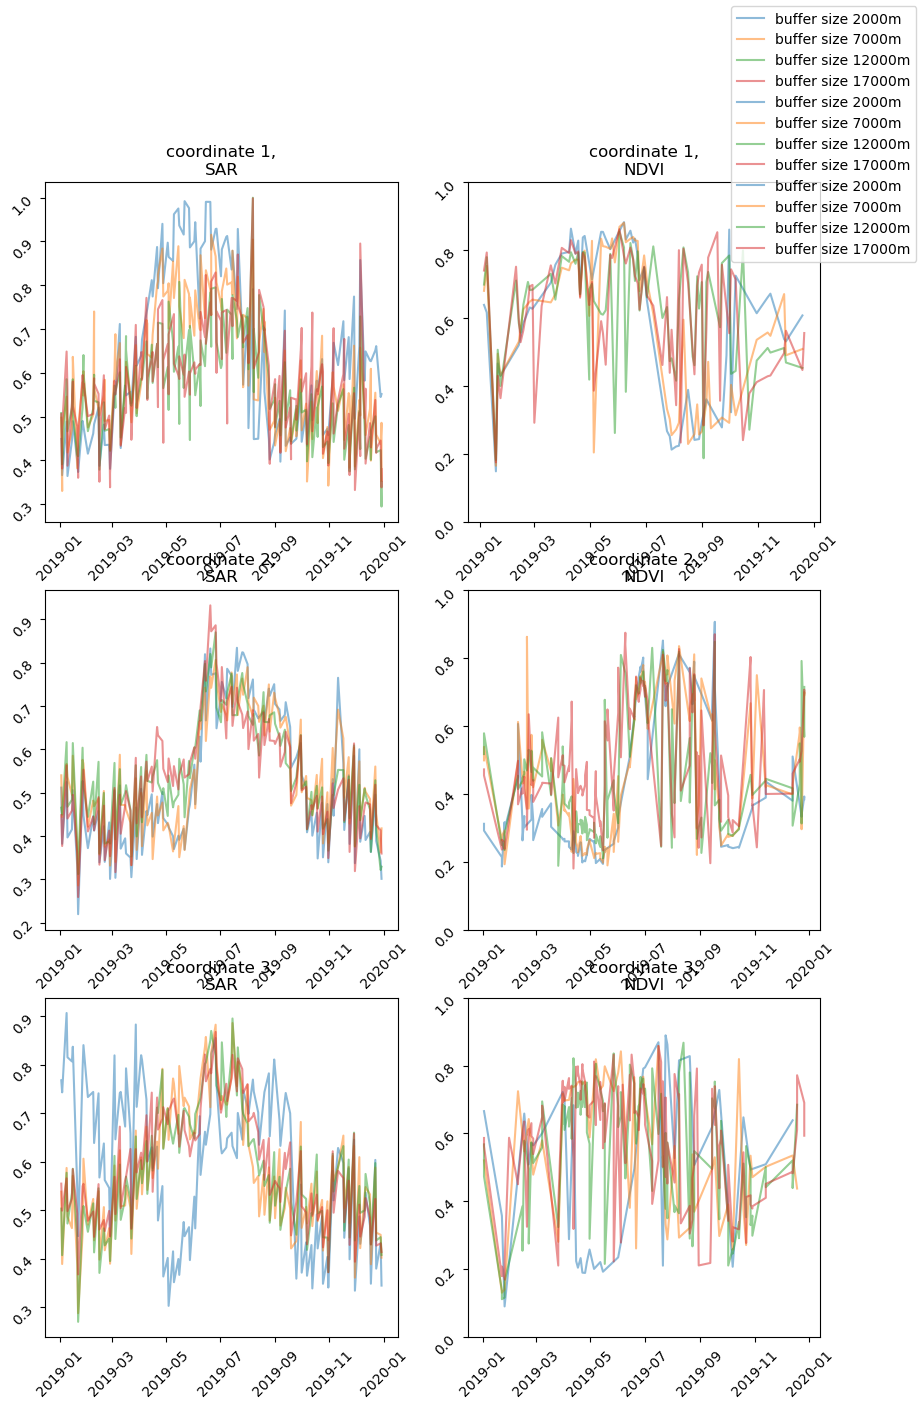

In [28]:
compare_averaging_width(reducer_code = 'median')

In [ ]:
compare_averaging_width(N = 200, widths = [7000, 8000, 9000],
                       coords = [np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')[0], 0])

1th coord
First download raw VV and VH


1th coord
First download raw VV and VH


KeyboardInterrupt: 

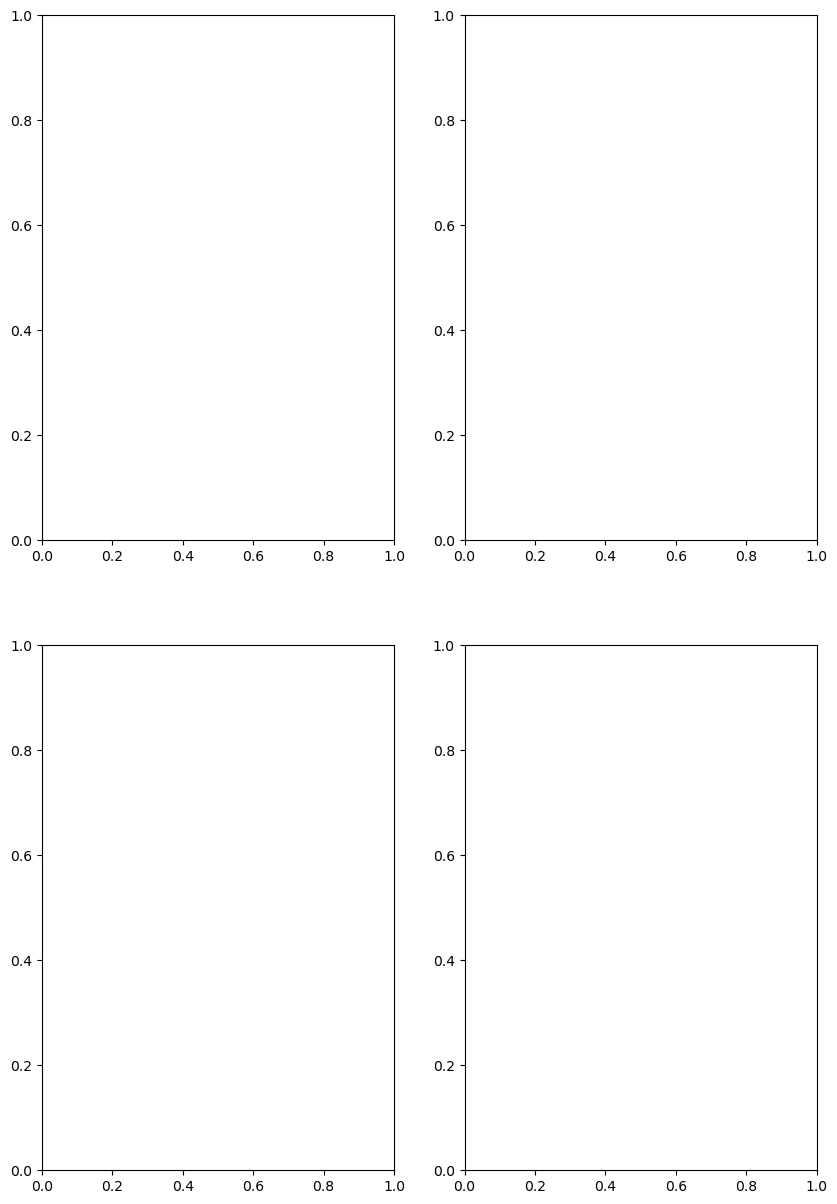

In [16]:
compare_averaging_width(widths = [7000, 8000, 9000, 10000, 11000, 12000],
                       coords = [np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')[0], 0])

In [23]:
def compare_scales(instrument = 'COPERNICUS/S1_GRD',
                            coords = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')[[0, 6]],
                            country = 'DE', crop_type = 'M', year = 2021, root_directory = '', N=200, reducer_code = 'mean',
                            SAR_bands = ['VV', 'VH'], img_index = 0, buffer_size = 1500, savename = False):
    fig, axs = plt.subplots(len(coords), 2, figsize = (10, 15))
    colour_list = ['blue', 'red', 'green', 'black', 'purple']
    linestyle_list = ['solid', 'solid', 'dotted', 'dashed', 'dashdot']
    for coord_index, coord in enumerate(coords):
        print(f'{coord_index + 1}th coord')
        for scale_param in [10, 50, 100, 150, 200, 250]:
            print('First download raw VV and VH')
            IC_SAR, vectors = initialise_comparison(instrument = instrument, coord = coord, 
                                                    country = country, crop_type = crop_type, 
                                                    year = year, root_directory = root_directory,
                                                    mask_scale=scale_param, buffer_size=buffer_size,
                                                    indices = False)
            vectors = vectors.map(lambda feat: feat.buffer(-50))
            random_points = ee.FeatureCollection.randomPoints(**{'region': vectors, 'points': N, 'seed': 46, 'maxError': 1})#
            ts = getTimeSeriesByRegion(IC_SAR, 
                                       reducer = [ee.Reducer.mean(),ee.Reducer.median(), ee.Reducer.max()], 
                                       geometry = random_points, 
                                       bands = SAR_bands, scale = scale_param)
            RVI = IC_SAR.map(rvi_from_s1_grd)
            ts = getTimeSeriesByRegion(RVI, 
                                       reducer = [ee.Reducer.mean(),ee.Reducer.median(), ee.Reducer.max()], 
                                       geometry = random_points, 
                                       bands = ['RVI'], scale = scale_param)
            try:
                x = geemap.ee_to_df(ts).sort_index(ascending=True)
            except:
                continue
            x['date'] = pd.to_datetime(x['date'])
            x = x.sort_values(by='date')
            x = x.where(x['RVI']!=-9999).dropna()
            x = x.where(x['RVI'] < 2).dropna()
            xreduced = x.where(x['reducer'] == reducer_code).dropna()
            #colour = ['blue', 'red', 'green', 'black', 'purple'][band_index + 1]
            #line_style = ['solid', 'solid', 'dotted', 'dashed', 'dashdot'][band_index + 1]
            axs[coord_index, 0].plot(xreduced['date'], (xreduced['RVI']/np.max([1, np.abs(xreduced['RVI']).max()]))*np.sign(xreduced['RVI'].max()), 
                                     label = f'{scale_param}m scale', alpha = 0.5)        
            print('Now compare to VIS')
            IC_VIS, vectors = initialise_comparison(instrument = 'COPERNICUS/S2_SR_HARMONIZED', coord = coord, 
                                                    country = country, crop_type = crop_type, 
                                                    year = year, root_directory = root_directory,
                                                    mask_scale=scale_param, buffer_size=buffer_size,
                                                    indices = True)
            vectors = vectors.map(lambda feat: feat.buffer(-50))
            masked = csPlus_mask_collection(IC_VIS)
            ts = getTimeSeriesByRegion(masked, 
                                       reducer = [ee.Reducer.mean(),ee.Reducer.median(), ee.Reducer.max()], 
                                       geometry = random_points, 
                                       bands = ['NDVI'], scale = scale_param)
            x = geemap.ee_to_df(ts)
            x['date'] = pd.to_datetime(x['date'])
            x = x.sort_values(by='date')
            x = x.where(x['NDVI']!=-9999).dropna()
            xreduced = x.where(x['reducer'] == reducer_code).dropna()
            axs[coord_index, 1].plot(xreduced['date'], (xreduced['NDVI']), 
                                     alpha = 0.5)
            axs[coord_index, 0].set_title(f'coordinate {coord_index + 1},\nSAR')
            axs[coord_index, 0].set_ylabel('RVI')
            axs[coord_index, 0].set_xlabel('Date')
            axs[coord_index, 1].set_title(f'coordinate {coord_index + 1},\nNDVI')
            axs[coord_index, 1].set_ylabel('NDVI')
            axs[coord_index, 1].set_xlabel('Date')
            axs[coord_index, 0].tick_params(labelrotation=45)
            axs[coord_index, 1].tick_params(labelrotation=45)
            axs[coord_index, 1].set_ylim([0, 1])    
    
    fig.legend()
    fig.tight_layout()
    if savename != False:
        fig.savefig(savename, bbox_inches='tight')

1th coord
First download raw VV and VH
Now compare to VIS
First download raw VV and VH
Now compare to VIS
First download raw VV and VH
Now compare to VIS
First download raw VV and VH
Now compare to VIS
First download raw VV and VH
Now compare to VIS
First download raw VV and VH
Now compare to VIS
2th coord
First download raw VV and VH
Now compare to VIS
First download raw VV and VH
Now compare to VIS
First download raw VV and VH
Now compare to VIS
First download raw VV and VH
Now compare to VIS
First download raw VV and VH
Now compare to VIS
First download raw VV and VH
Now compare to VIS


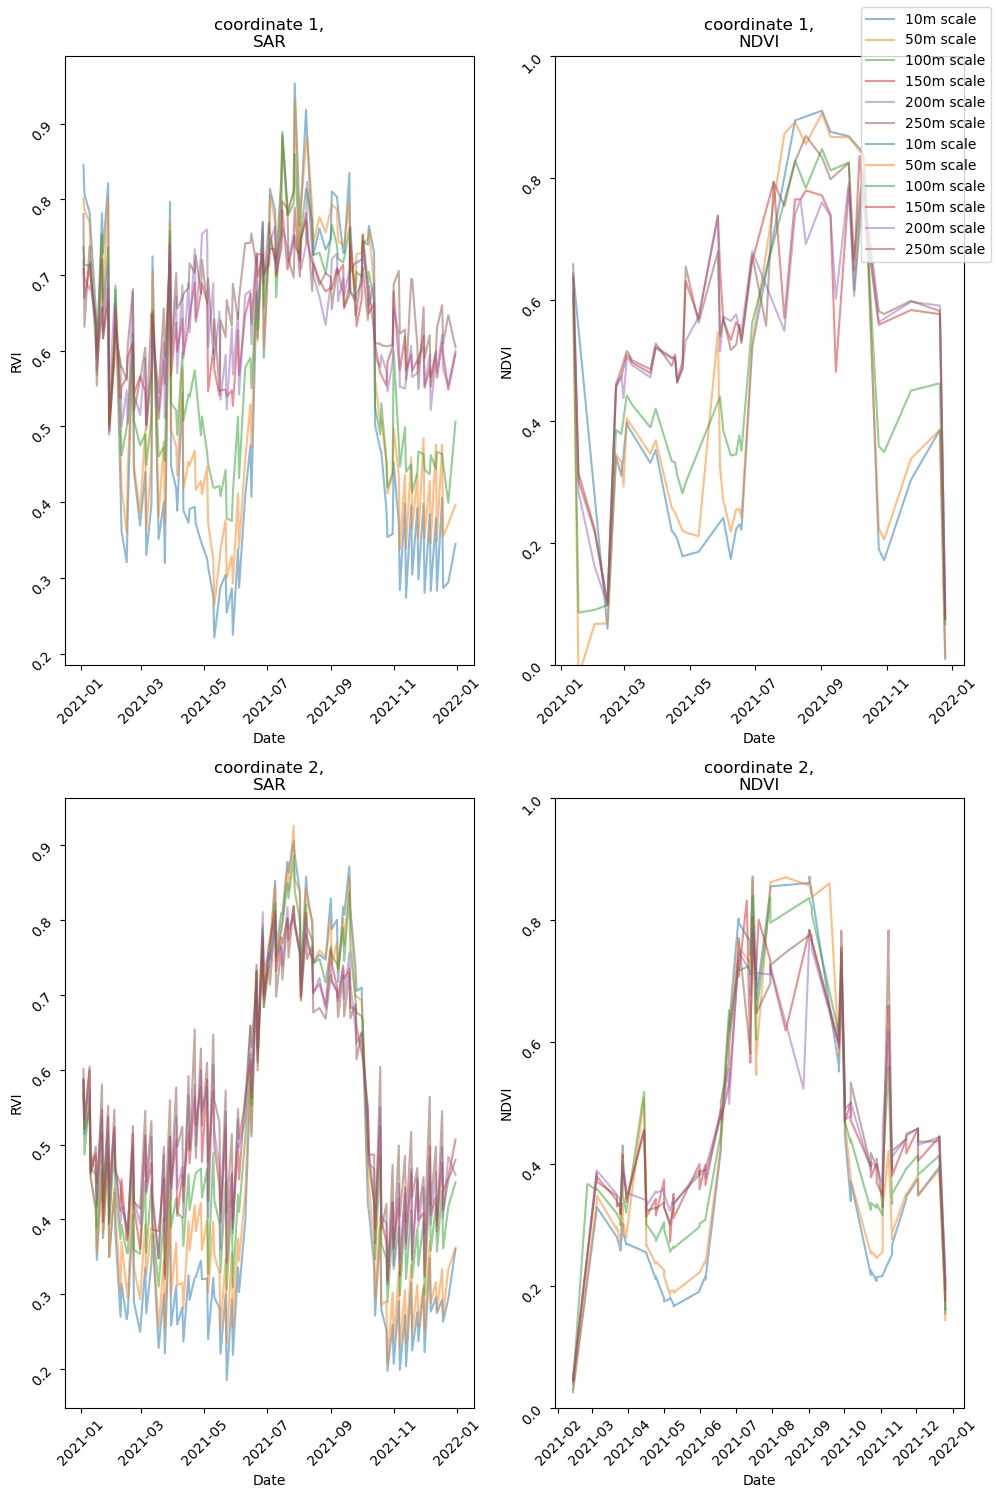

In [24]:
compare_scales(buffer_size = 1500, N = 200, savename = 'Plots/compare_scales.png')

In [20]:
def plot_SAR_bands(instrument = 'COPERNICUS/S1_GRD',
                       coords = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')[0:3],
                      country = 'DE', crop_type = 'M', year = 2019, root_directory = '', N=1, reducer_code = 'mean',
                      mask_scale=10, buffer_size=1500, SAR_bands = ['VV', 'VH'], img_index = 0):
    fig, axs = plt.subplots(len(coords), 1, figsize = (10, 15))
    colour_list = ['blue', 'red', 'green', 'black', 'purple']
    linestyle_list = ['solid', 'solid', 'dotted', 'dashed', 'dashdot']
    for coord_index, coord in enumerate(coords):
        print(f'{coord_index + 1}th coord')
        print('First download raw VV and VH')
        IC_SAR, vectors = initialise_comparison(instrument = instrument, coord = coord, 
                                                country = country, crop_type = crop_type, 
                                                year = year, root_directory = root_directory,
                                                mask_scale=mask_scale, buffer_size=buffer_size,
                                                indices = False)
        location = box_around_point(coord, 0.01)
        
        random_points = ee.FeatureCollection.randomPoints(**{'region': vectors, 'points': N, 'seed': 46, 'maxError': 1})#
        ts = getTimeSeriesByRegion(IC_SAR, 
                                   reducer = [ee.Reducer.mean(),ee.Reducer.median(), ee.Reducer.max()], 
                                   geometry = random_points, 
                                   bands = SAR_bands, scale = mask_scale)
        try:
            x = geemap.ee_to_df(ts)
            x['date'] = pd.to_datetime(x['date'])
            x = x.sort_values(by='date')
            x = x.where(x['VV']!=-9999).dropna()
            xreduced = x.where(x['reducer'] == reducer_code).dropna()
            xreduced['CR'] = xreduced['VH']/xreduced['VV']
        except:
            continue
        for band_index, SAR_band in enumerate(SAR_bands + ['CR']):
            colour = ['blue', 'red', 'green', 'black', 'purple'][band_index]
            line_style = ['solid', 'solid', 'dotted', 'dashed', 'dashdot'][band_index]
            print(xreduced[SAR_band].max(), np.sign(xreduced[SAR_band].max()))
            axs[coord_index].plot(xreduced['date'], (xreduced[SAR_band]/np.max([1, np.abs(xreduced[SAR_band]).max()]))*np.sign(xreduced[SAR_band].mean()), c = colour, label = SAR_band)
        
        print('Now convert to RVI')
        RVI = IC_SAR.map(rvi_from_s1_grd)
        ts = getTimeSeriesByRegion(RVI, 
                                   reducer = [ee.Reducer.mean(),ee.Reducer.median(), ee.Reducer.max()], 
                                   geometry = random_points, 
                                   bands = ['RVI'], scale = mask_scale)
        
        x = geemap.ee_to_df(ts).sort_index(ascending=True)
        x['date'] = pd.to_datetime(x['date'])
        x = x.sort_values(by='date')
        x = x.where(x['RVI']!=-9999).dropna()
        x = x.where(x['RVI'] < 2).dropna()
        xreduced = x.where(x['reducer'] == reducer_code).dropna()
        colour = ['blue', 'red', 'green', 'black', 'purple'][band_index + 1]
        line_style = ['solid', 'solid', 'dotted', 'dashed', 'dashdot'][band_index + 1]
        axs[coord_index].plot(xreduced['date'], (xreduced['RVI']/np.max([1, np.abs(xreduced['RVI']).max()]))*np.sign(xreduced['RVI'].max()), c = colour, linestyle = line_style, label = 'RVI')
    
        print('Now compare to VIS')
        IC_VIS, vectors = initialise_comparison(instrument = 'COPERNICUS/S2_SR_HARMONIZED', coord = coord, 
                                                country = country, crop_type = crop_type, 
                                                year = year, root_directory = root_directory,
                                                mask_scale=mask_scale, buffer_size=buffer_size,
                                                indices = True)
        
        masked = csPlus_mask_collection(IC_VIS)
        ts = getTimeSeriesByRegion(masked, 
                                   reducer = [ee.Reducer.mean(),ee.Reducer.median(), ee.Reducer.max()], 
                                   geometry = random_points, 
                                   bands = ['NDVI'], scale = mask_scale)
        x = geemap.ee_to_df(ts)
        x['date'] = pd.to_datetime(x['date'])
        x = x.sort_values(by='date')
        x = x.where(x['NDVI']!=-9999).dropna()
        xreduced = x.where(x['reducer'] == reducer_code).dropna()
        colour = colour_list[band_index + 2]
        line_style = linestyle_list[band_index + 2]
        axs[coord_index].plot(xreduced['date'], (xreduced['NDVI']), c = colour, label = 'NDVI', linestyle = line_style)
        axs[coord_index].set_title('SAR vs NDVI')
        axs[coord_index].tick_params(labelrotation=45)
        axs[coord_index].set_ylim([0, 1])    
    
    fig.legend()
    #

1th coord
First download raw VV and VH
-6.845707421817235 -1.0
-14.162066385673317 -1.0
2.4469305980038163 1.0
Now convert to RVI
Now compare to VIS
2th coord
First download raw VV and VH
-8.356253999288104 -1.0
-15.067237607507888 -1.0
2.4119863786941957 1.0
Now convert to RVI
Now compare to VIS
3th coord
First download raw VV and VH
-7.443338460696652 -1.0
-15.200980262337485 -1.0
2.4730917262841072 1.0
Now convert to RVI
Now compare to VIS


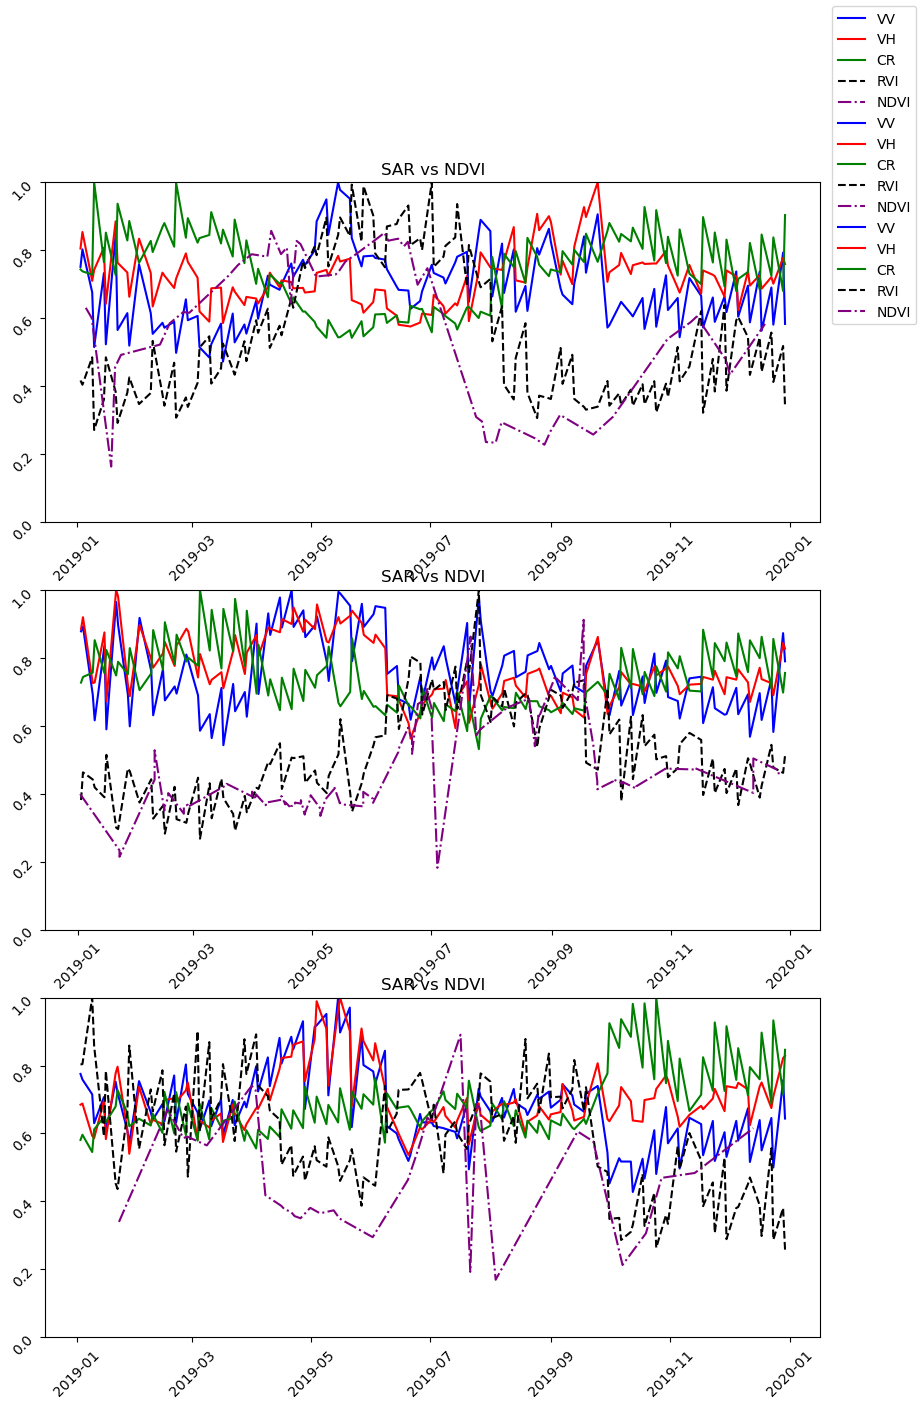

In [250]:
plot_SAR_bands(N = 30, coords = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')[[0, 6, 8]], reducer_code = 'mean')

In [25]:
def compare_veg_indices(instrument = 'COPERNICUS/S2_SR_HARMONIZED',
                       coords = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')[0:3],
                      country = 'DE', crop_type = 'M', year = 2019, root_directory = '', N=1, reducer_code = 'median',
                      mask_scale=10, buffer_size=1500, bands = ['EVI','NDVI', 'SAVI', 'NDWI', 'CIG']):
    fig, axs = plt.subplots(len(coords), 1, figsize = (10, 15))
    for coord_index, coord in enumerate(coords):
        IC, vectors = initialise_comparison(instrument = instrument, coord = coord, 
                                            country = country, crop_type = crop_type, 
                                            year = year, root_directory = root_directory,
                                           mask_scale=mask_scale, buffer_size=buffer_size,
                                           spectral_indices = bands)
        masked = csPlus_mask_collection(IC)
        vectors = vectors.map(lambda feat: feat.buffer(-50))
        random_points = ee.FeatureCollection.randomPoints(**{'region': vectors, 'points': N, 'seed': 46, 'maxError': 1})#
        ts = getTimeSeriesByRegion(masked,
            reducer = [ee.Reducer.mean(),ee.Reducer.median(), ee.Reducer.max()],
            geometry = random_points,
            bands = bands,#['B4','B8'],
            scale = mask_scale)
        x = geemap.ee_to_df(ts)
        for VI_index, veg_index in enumerate(bands):
            x['date'] = pd.to_datetime(x['date'])
            x = x.where(x['NDVI']!=-9999).dropna()
            xreduced = x.where(x['reducer'] == reducer_code).dropna()
            colour = ['blue', 'red', 'green', 'black', 'purple'][VI_index]
            line_style = ['solid', 'solid', 'dotted', 'dashed', 'dashdot'][VI_index]
            if coord_index == 0:
                axs[coord_index].plot(xreduced['date'], (xreduced[veg_index]/np.max([1, xreduced[veg_index].max()]))*np.sign( xreduced[veg_index].max()),
                                      c = colour, label = veg_index, linestyle = line_style)
            else:
                axs[coord_index].plot(xreduced['date'], (xreduced[veg_index]/np.max([1, xreduced[veg_index].max()]))*np.sign( xreduced[veg_index].max()),
                                      c = colour, linestyle = line_style)
        axs[coord_index].set_title('Comparing different VIs')
        axs[coord_index].tick_params(labelrotation=45)
        axs[coord_index].set_ylim([0, 1])
    fig.legend()
    fig.tight_layout()

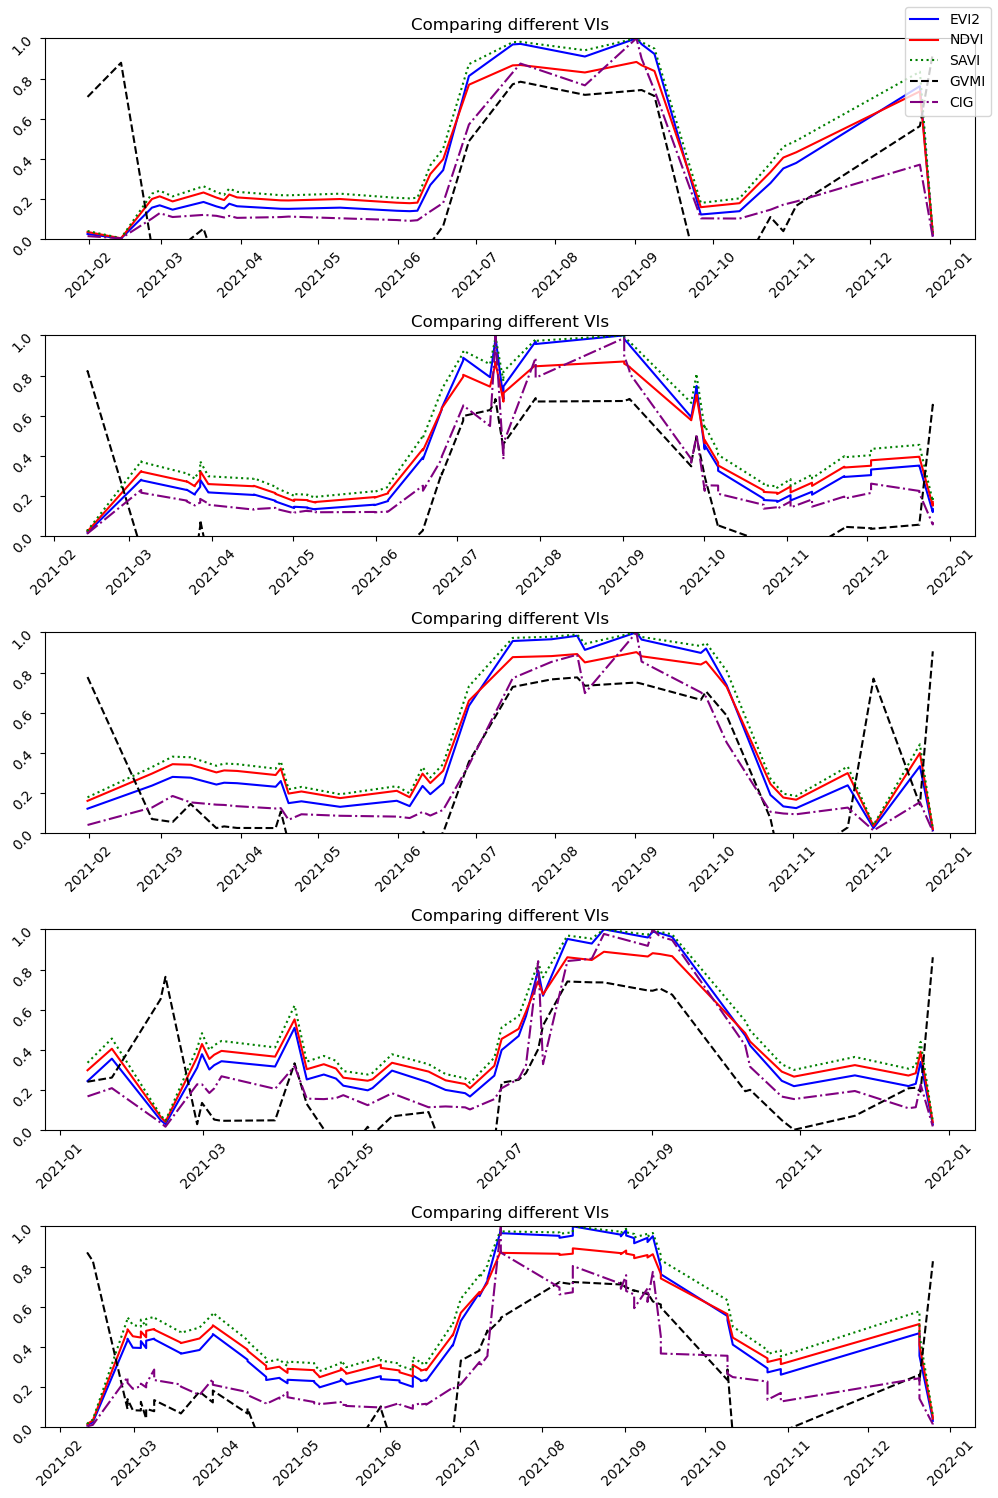

In [26]:
compare_veg_indices(reducer_code = 'mean', coords = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')[[3, 6, 8, 10, 11]], 
                    mask_scale = 10, buffer_size=1500, crop_type = 'M',
                   bands = ['EVI2','NDVI', 'SAVI', 'GVMI', 'CIG'], N = 100, year = 2021)

In [176]:
#compare_veg_indices(reducer_code = 'mean', coords = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')[[3, 6, 8]], mask_scale = 500, buffer_size=5000, crop_type = 'M',
#                   bands = ['NDVI', 'BNDVI', 'EVI2','CVI', 'CIG'])

In [177]:
#compare_veg_indices(reducer_code = 'mean', coords = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')[[3, 6, 8]], mask_scale = 500, buffer_size=5000, crop_type = 'M',
#                   bands = ['NDVI', 'GARI', 'GBNDVI','GLI', 'GNDVI'])

In [178]:
#compare_veg_indices(reducer_code = 'mean', coords = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')[[3, 6, 7, 8, 9]], mask_scale = 500, buffer_size=5000, crop_type = 'M',
#                   bands = ['NDVI', 'GVMI', 'RVI', 'SAVI', 'VARI'], year=2020)

In [25]:
def compare_crop_masks(instrument = 'COPERNICUS/S2_SR_HARMONIZED',
                       coords = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')[0:2],
                      country = 'DE', crop_type = 'M', year = 2019, root_directory = '', N=1, reducer_code = 'median',
                      mask_scale=10, buffer_size=1500):
    fig, axs = plt.subplots(1, 3, figsize = (20, 10))
    for mask_index in range(3):
        first_coord = True
        for coord in coords:
            print(coord)
            if mask_index == 0:
                IC, vectors = initialise_comparison(instrument = instrument, coord = coord, 
                                                    country = country, crop_type = crop_type, 
                                                    year = year, root_directory = root_directory,
                                                   mask_scale=mask_scale, buffer_size=buffer_size)
            elif mask_index == 1:
                IC, vectors = initialise_comparison(instrument = instrument, coord = coord, 
                                                    country = country, crop_type = crop_type, 
                                                    year = year, root_directory = root_directory, just_eujrc = True,
                                                   mask_scale=mask_scale, buffer_size=buffer_size)
            elif mask_index == 2:
                IC, vectors = initialise_comparison(instrument = instrument, coord = coord, 
                                                    country = country, crop_type = crop_type, 
                                                    year = year, root_directory = root_directory, combine_eujrc = True,
                                                   mask_scale=mask_scale, buffer_size=buffer_size)
            masked = csPlus_mask_collection(IC)
            vectors = vectors.map(lambda feat: feat.buffer(-100))
            random_points = ee.FeatureCollection.randomPoints(**{'region': vectors, 'points': N, 'seed': 46, 'maxError': 1})#
            ts = getTimeSeriesByRegion(masked,
                reducer = [ee.Reducer.mean(),ee.Reducer.median(), ee.Reducer.max()],
                geometry = random_points,
                bands = ['EVI','NDVI'],#['B4','B8'],
                scale = mask_scale)
            try:
                x = geemap.ee_to_df(ts)
            except:
                continue
            x['date'] = pd.to_datetime(x['date'])
            x = x.where(x['NDVI']!=-9999).dropna()
            name_choices = ['s2 cloud mask', 'google cloud mask']
            xreduced = x.where(x['reducer'] == reducer_code).dropna()
            colour = ['blue', 'red', 'green'][mask_index]
            if first_coord:
                mask_name = ['World cereal',
                             'EUJRC',
                             'World cereal and EUJRC'][mask_index]
                axs[mask_index].plot(xreduced['date'], xreduced['NDVI'], 
                                     alpha = 0.5, c = colour,
                                     label = f'Using {mask_name} crop masks, {reducer_code} reduced')
                first_coord = False
            else:
                axs[mask_index].plot(xreduced['date'], xreduced['NDVI'], 
                         alpha = 0.5, c=colour)
            axs[mask_index].set_title(mask_name)
            axs[mask_index].tick_params(labelrotation=45)
    fig.legend()
    fig.tight_layout()

[  54.3167   10.05   7504.    ]
[  54.4333    9.8167 7521.    ]
[  54.4       8.7667 7532.    ]
[  54.3167   10.05   7504.    ]
[  54.4333    9.8167 7521.    ]
[  54.4       8.7667 7532.    ]
[  54.3167   10.05   7504.    ]
[  54.4333    9.8167 7521.    ]
[  54.4       8.7667 7532.    ]


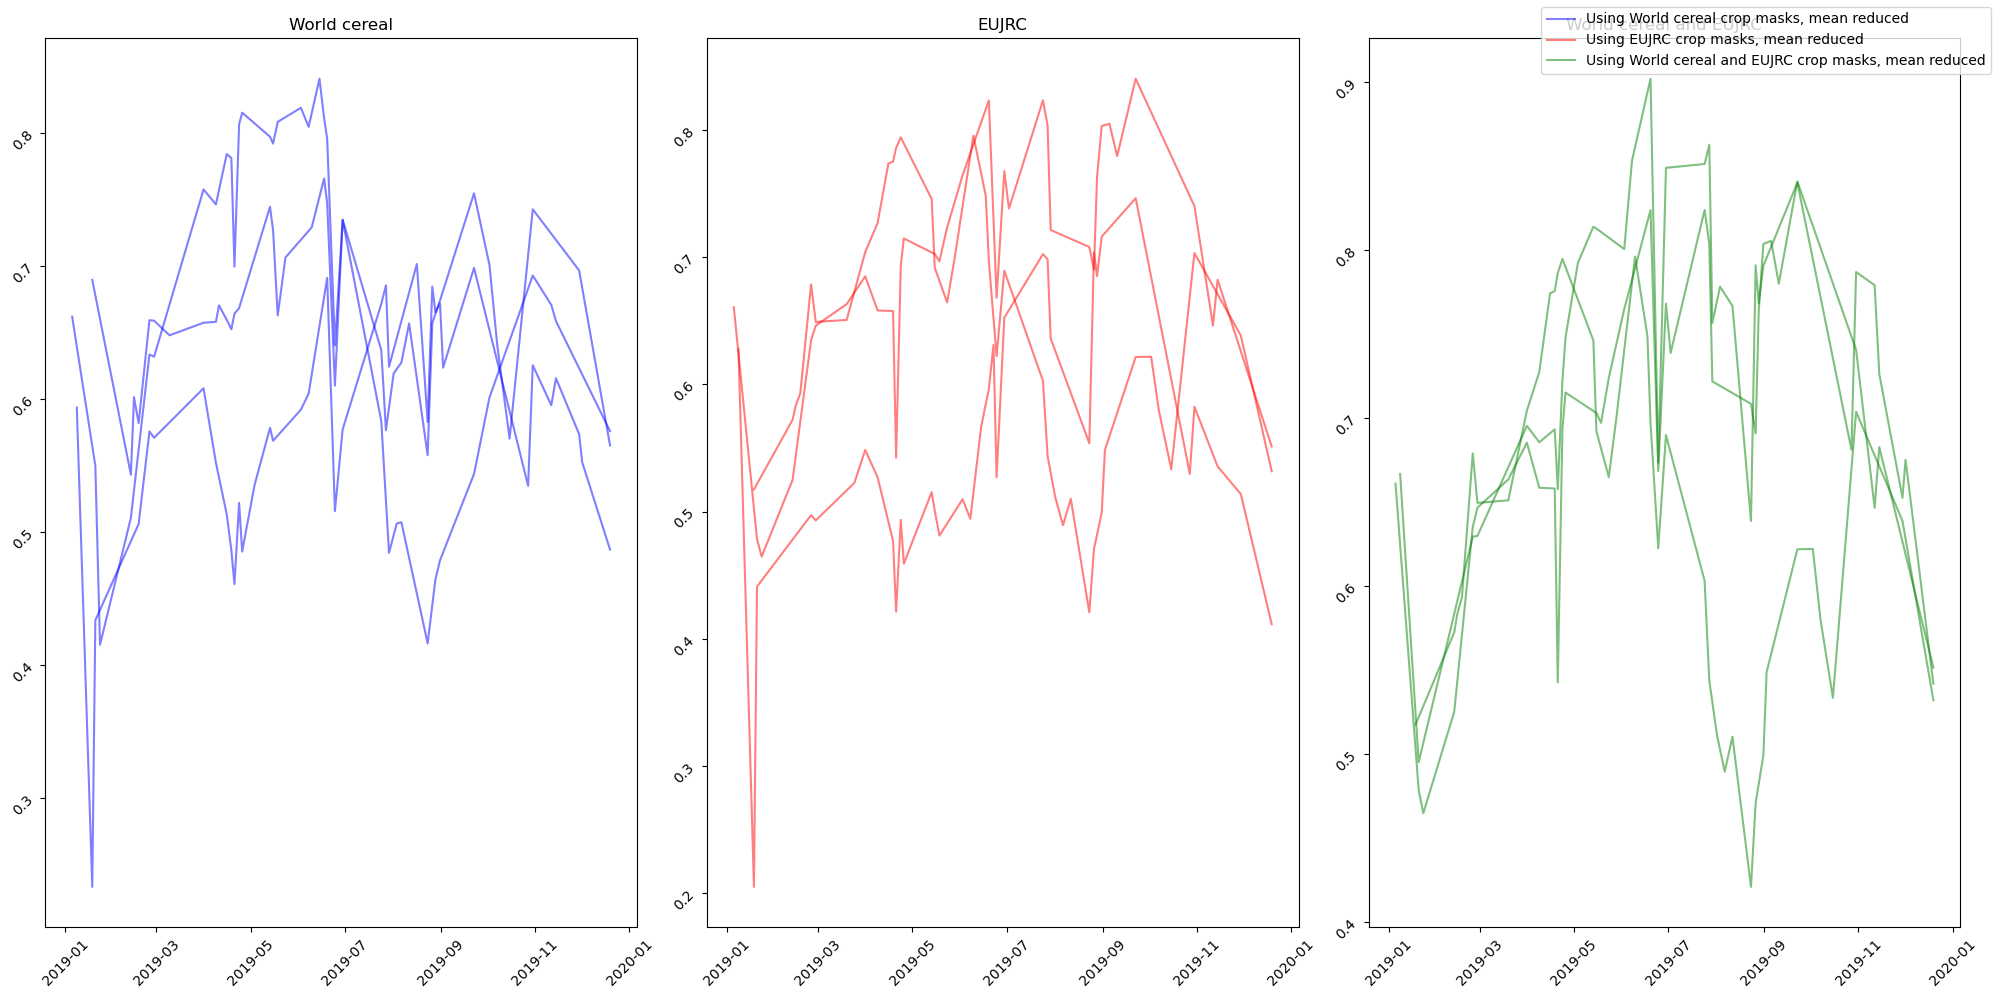

In [26]:
compare_crop_masks(reducer_code = 'mean', coords = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')[0:3], mask_scale = 1000, buffer_size=5000, crop_type = 'ww')

In [16]:
def compare_cloud_masks(instrument = 'COPERNICUS/S2_SR_HARMONIZED', 
                                 coord = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')[1],
                                 country = 'DE', crop_type = 'M', year = 2019, root_directory = '',
                                reducer_code = 'median', N=1):
    IC, vectors = initialise_comparison(instrument = instrument, coord = coord, country = country, crop_type = crop_type, year = year, root_directory = root_directory)
    fig, ax = plt.subplots()
    for index, masker in enumerate([mask_s2_clouds_collection, csPlus_mask_collection]):
        masked = masker(IC)
        random_points = ee.FeatureCollection.randomPoints(**{'region': vectors, 'points': N, 'seed': 46, 'maxError': 1})#
        ts = getTimeSeriesByRegion(masked,
            reducer = [ee.Reducer.mean(),ee.Reducer.median(), ee.Reducer.max()],
            geometry = random_points,
            bands = ['EVI','NDVI'],#['B4','B8'],
            scale = 10)
        x = geemap.ee_to_df(ts)
        x['date'] = pd.to_datetime(x['date'])
        x = x.where(x['NDVI']!=-9999).dropna()
        name_choices = ['s2 cloud mask', 'google cloud mask']
        xreduced = x.where(x['reducer'] == reducer_code).dropna()
        ax.plot(xreduced['date'], xreduced['NDVI'], label = f'{name_choices[index]}, {reducer_code} reduced')
    fig.legend()
                                 

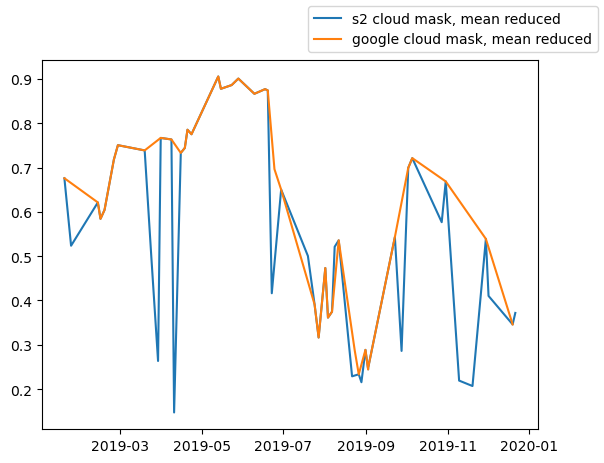

In [17]:
compare_cloud_masks(reducer_code = 'mean', coord = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')[2])

In [18]:
def compare_reducers(instrument = 'COPERNICUS/S2_SR_HARMONIZED',
                     coord = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')[0],
                     country = 'DE', crop_type = 'M', year = 2021, root_directory = '',
                     reducer_code = 'median', mask_scale = 10, buffer_size = 1500,
                    N=100):
    IC, vectors = initialise_comparison(instrument = instrument, coord = coord, 
                                                 country = country, crop_type = crop_type, 
                                                 year = year, root_directory = root_directory,
                                                mask_scale = mask_scale, buffer_size = buffer_size)
    vectors = vectors.map(lambda feat: feat.buffer(-50))
    masked = csPlus_mask_collection(IC)
    random_points = ee.FeatureCollection.randomPoints(**{'region': vectors, 'points': N, 'seed': 46, 'maxError': 1})#
    
    ts = getTimeSeriesByRegion(masked,
        reducer = [ee.Reducer.mean(),ee.Reducer.median(), ee.Reducer.max()],
        geometry = random_points,
        bands = ['EVI','NDVI'],#['B4','B8'],
        scale = 10)
    x = geemap.ee_to_df(ts)
    x['date'] = pd.to_datetime(x['date'])
    x = x.where(x['NDVI']!=-9999).dropna()
    xmean = x.where(x['reducer'] == 'mean').dropna()
    xmedian = x.where(x['reducer'] == 'median').dropna()
    xmax = x.where(x['reducer'] == 'max').dropna()
    name_choices = ['s2 cloud mask', 'google cloud mask']
    fig, ax = plt.subplots()
    ax.plot(xmean['date'], xmean['NDVI'], label = f'google cloud mask, mean reduced')
    ax.plot(xmedian['date'], xmedian['NDVI'], label = f'google cloud mask, median reduced')
    ax.plot(xmax['date'], xmax['NDVI'], label = f'google cloud mask, max reduced')
    fig.legend()

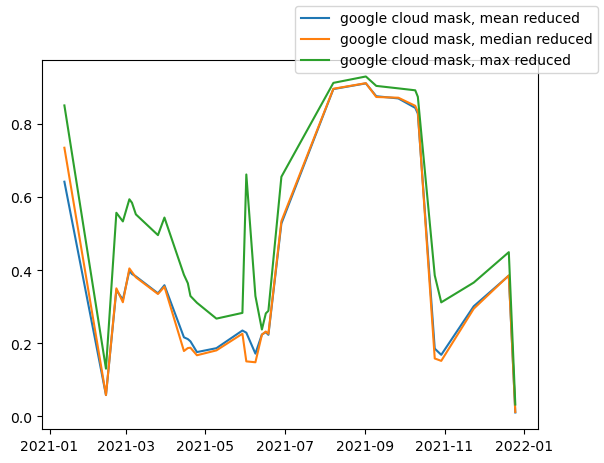

In [19]:
compare_reducers()

In [216]:
def compare_reducers_SAR(instrument = 'COPERNICUS/S1_GRD',
                     coord = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')[1],
                     country = 'DE', crop_type = 'M', year = 2019, root_directory = '',
                     reducer_code = 'median', mask_scale = 250, buffer_size = 3000):
    N = 30
    fig, ax = plt.subplots(figsize = (10, 10))
    IC_SAR, vectors = initialise_comparison(instrument = instrument, coord = coord, 
                                            country = country, crop_type = crop_type, 
                                            year = year, root_directory = root_directory,
                                           mask_scale=mask_scale, buffer_size=buffer_size,
                                           indices = False)
    random_points = ee.FeatureCollection.randomPoints(**{'region': vectors, 'points': N, 'seed': 46, 'maxError': 1})#
    RVI = IC_SAR.map(rvi_from_s1_grd)
    #RVI_outlier_mask = RVI.lt(1.5)
    RVI = IC_less_than(RVI, 1.5)
    #RVI = RVI.updateMask(RVI_outlier_mask)
    ts = getTimeSeriesByRegion(RVI,
        reducer = [ee.Reducer.mean(),ee.Reducer.median(), ee.Reducer.max()],
        geometry = random_points,
        bands = ['RVI'],#['B4','B8'],
        scale = mask_scale)
    x = geemap.ee_to_df(ts)
    x['date'] = pd.to_datetime(x['date'])
    x = x.sort_values(by='date')
    x = x.where(x['RVI']!=-9999).dropna()
    x = x.where(x['RVI'] < 2).dropna()
    xmean = x.where(x['reducer'] == 'mean').dropna()
    xmedian = x.where(x['reducer'] == 'median').dropna()
    xmax = x.where(x['reducer'] == 'max').dropna()
    name_choices = ['s2 cloud mask', 'google cloud mask']
    ax.plot(xmean['date'], xmean['RVI'], label = f'google cloud mask, mean reduced')
    ax.plot(xmedian['date'], xmedian['RVI'], label = f'google cloud mask, median reduced')
    ax.plot(xmax['date'], xmax['RVI'], label = f'google cloud mask, max reduced')
    fig.legend()

In [204]:
def img_less_than(img, upper_bound):
    new_mask = img.lt(upper_bound)
    return img.updateMask(new_mask)

In [205]:
def IC_less_than(IC, upper_bound):
    return IC.map(lambda img: img_less_than(img, upper_bound))

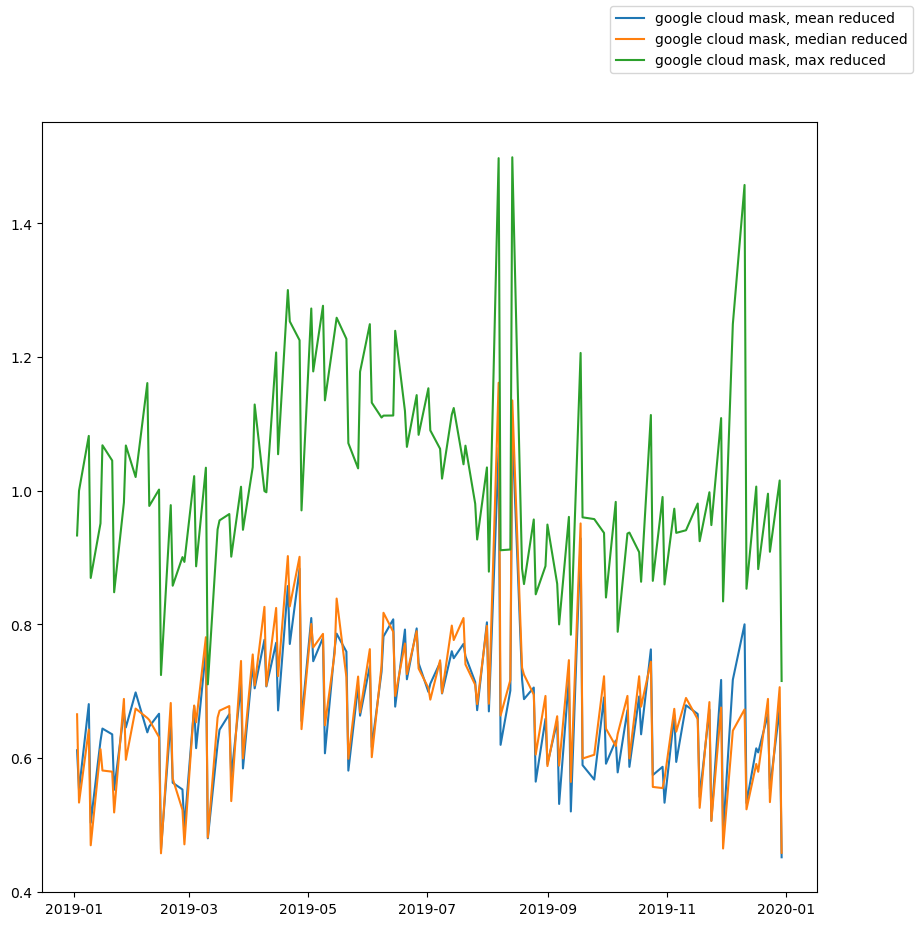

In [217]:
compare_reducers_SAR()

In [11]:
def compare_sample_sizes(instrument = 'COPERNICUS/S2_SR_HARMONIZED',
                     coords = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')[0:5],
                     country = 'DE', crop_type = 'M', year = 2019, root_directory = '',
                     reducer_code = 'median', buffer_size = 1500,
                        mask_scale = 10):
    fig, ax = plt.subplots(len(coords), 1, figsize = (10, 5))
    for coord_index, coord in enumerate(coords):
        print(f'Coordinate {coord_index + 1}')
        IC, vectors = initialise_comparison(instrument = instrument, coord = coord, 
                                            country = country, crop_type = crop_type, 
                                            year = year, root_directory = root_directory,
                                           mask_scale = mask_scale,
                                           buffer_size=buffer_size)
        vectors = vectors.map(lambda feat: feat.buffer(-50))
        for N in range(1, 1000, 100):
            masked = csPlus_mask_collection(IC)
            random_points = ee.FeatureCollection.randomPoints(**{'region': vectors, 'points': N, 'seed': 43, 'maxError': 1})#
            ts = getTimeSeriesByRegion(masked,
                reducer = [ee.Reducer.mean(),ee.Reducer.median(), ee.Reducer.max()],
                geometry = random_points,
                bands = ['EVI','NDVI'],#['B4','B8'],
                scale = 10)
            x = geemap.ee_to_df(ts)
            x['date'] = pd.to_datetime(x['date'])
            x = x.where(x['NDVI']!=-9999).dropna()
            xreduced = x.where(x['reducer'] == reducer_code).dropna()
            ax[coord_index].plot(xreduced['date'], xreduced['NDVI'], label = f'Google cloud mask, {reducer_code} reduced')
        if coord_index == 0:
            fig.legend()

In [184]:
def compare_sample_sizes_SAR(instrument = 'COPERNICUS/S1_GRD',
                     coords = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')[0:3],
                     country = 'DE', crop_type = 'M', year = 2019, root_directory = '',
                     reducer_code = 'mean', mask_scale = 100, buffer_size = 1500):
    fig, axs = plt.subplots(len(coords), 1, figsize = (10, 10))
    for coord_index, coord in enumerate(coords):
        print(f'Coordinate {coord_index + 1}')
        IC_SAR, vectors = initialise_comparison(instrument = instrument, coord = coord, 
                                                country = country, crop_type = crop_type, 
                                                year = year, root_directory = root_directory,
                                               mask_scale=mask_scale, buffer_size=buffer_size,
                                               indices = False)
        for N in range(1, 100, 30):
            #random_points = ee.FeatureCollection.randomPoints(**{'region': vectors, 'points': N, 'seed': 43, 'maxError': 1})#
            random_points = ee.FeatureCollection.randomPoints(**{'region': vectors, 'points': N, 'seed': 46, 'maxError': 1})#
            RVI = IC_SAR.map(rvi_from_s1_grd)
            ts = getTimeSeriesByRegion(RVI,
                reducer = [ee.Reducer.mean(),ee.Reducer.median(), ee.Reducer.max()],
                geometry = random_points,
                bands = ['RVI'],#['B4','B8'],
                scale = mask_scale)
            x = geemap.ee_to_df(ts).sort_index(ascending=True)
            x['date'] = pd.to_datetime(x['date'])
            x = x.sort_values(by='date')
            x = x.where(x['RVI']!=-9999).dropna()
            xreduced = x.where(x['reducer'] == reducer_code).dropna()
            xreduced = xreduced.where(xreduced['RVI'] < 1).dropna()
            axs[coord_index].plot(xreduced['date'], (xreduced['RVI']),#/np.max([1, np.abs(xreduced['RVI']).max()]))*np.sign(xreduced['RVI'].max()),
                                  label = f'RVI, {N} samples')
            if coord_index == 0:
                fig.legend()

Coordinate 1
Coordinate 2
Coordinate 3


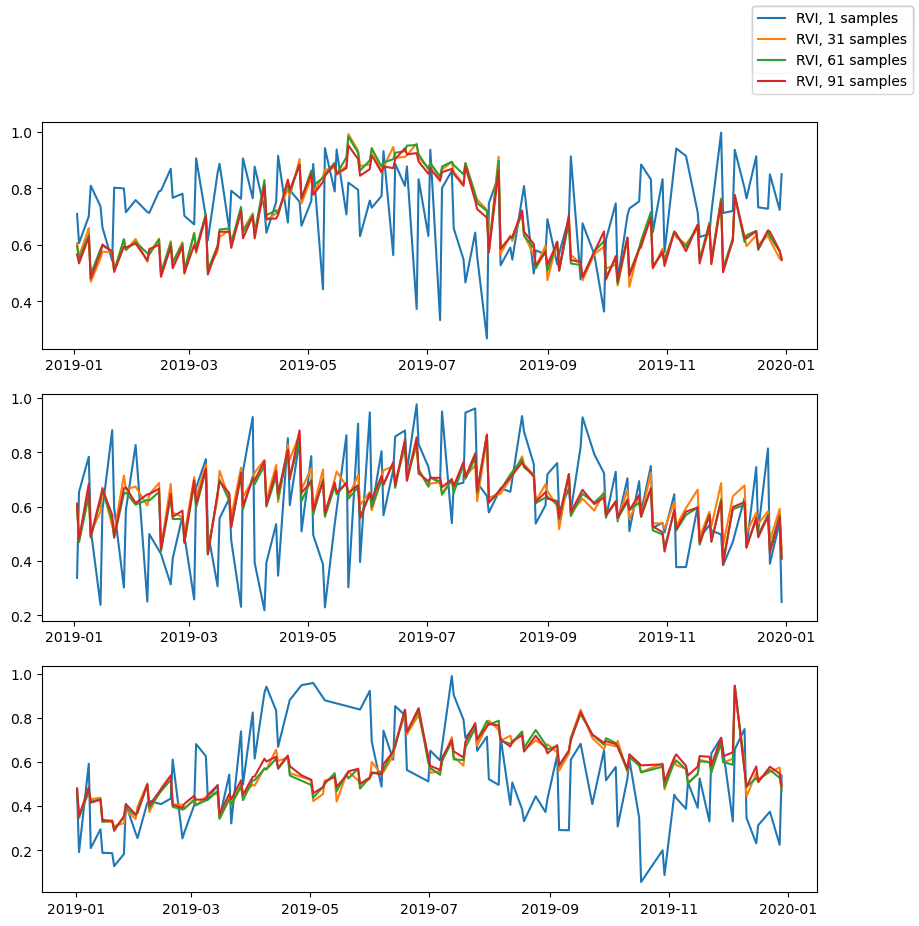

In [185]:
compare_sample_sizes_SAR()

Coordinate 1
Coordinate 2
Coordinate 3


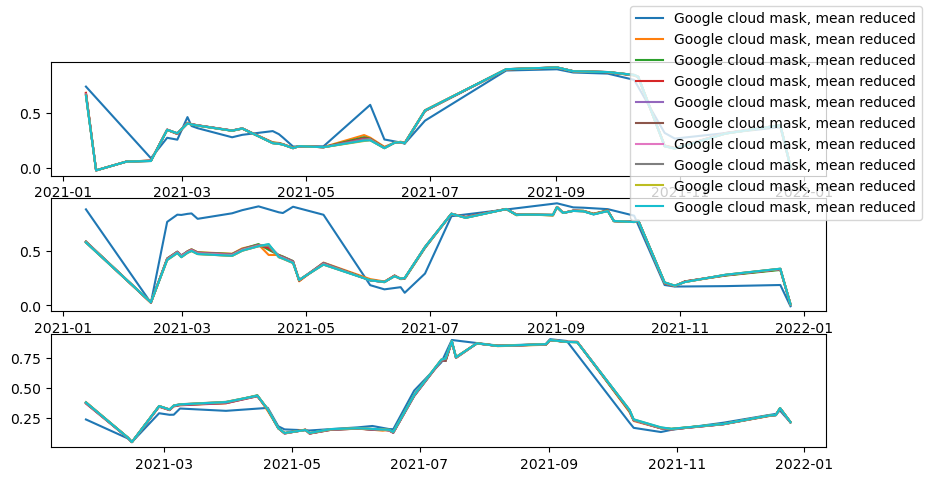

In [12]:
compare_sample_sizes(reducer_code = 'mean', 
                     coords = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')[0:3],
                    year = 2021)

In [15]:
def get_image_index(image_collection, index):
    imgList = image_collection.toList(999)
    return ee.Image(ee.List(imgList).get(index))

In [18]:
def box_around_point(coord, box_width):
    '''
    coord: coordinate in (lat, lon) (?)
    '''
    return ee.Geometry.BBox(coord[1] - box_width, coord[0] - box_width, coord[1] + box_width, coord[0] + box_width)

In [26]:
def compare_images(instrument = 'COPERNICUS/S2_SR_HARMONIZED',
                     coord = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')[1],
                     country = 'DE', crop_type = 'M', year = 2019, root_directory = '',
                     reducer_code = 'median'):
    fig, ax, IC, vectors = initialise_comparison(instrument = instrument, coord = coord, country = country, crop_type = crop_type, year = year, root_directory = root_directory)
    masked = csPlus_mask_collection(IC)
    IC = IC.filterMetadata('CLOUDY_PIXEL_PERCENTAGE','less_than',50)
    location = box_around_point(coord, 0.01)
    fig, axs = plt.subplots(4, 5, figsize = (24, 60))
    for index in range(20):
        img2ndImage=get_image_index(masked, index)
        img2ndImage.geetools.plot(bands = ['NDVI'], ax = axs[index // 5, index % 5], region=location,cmap="viridis",
                              color="k")
    fig.savefig('manyplots.jpg')
    

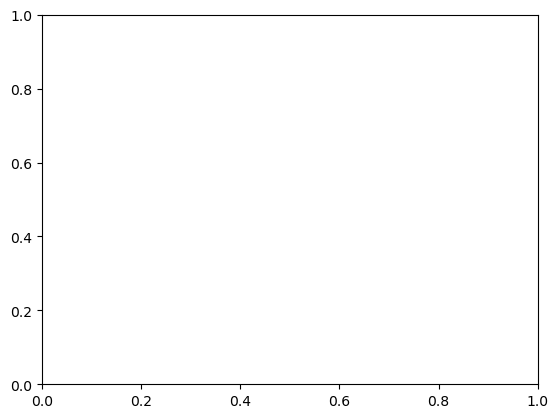

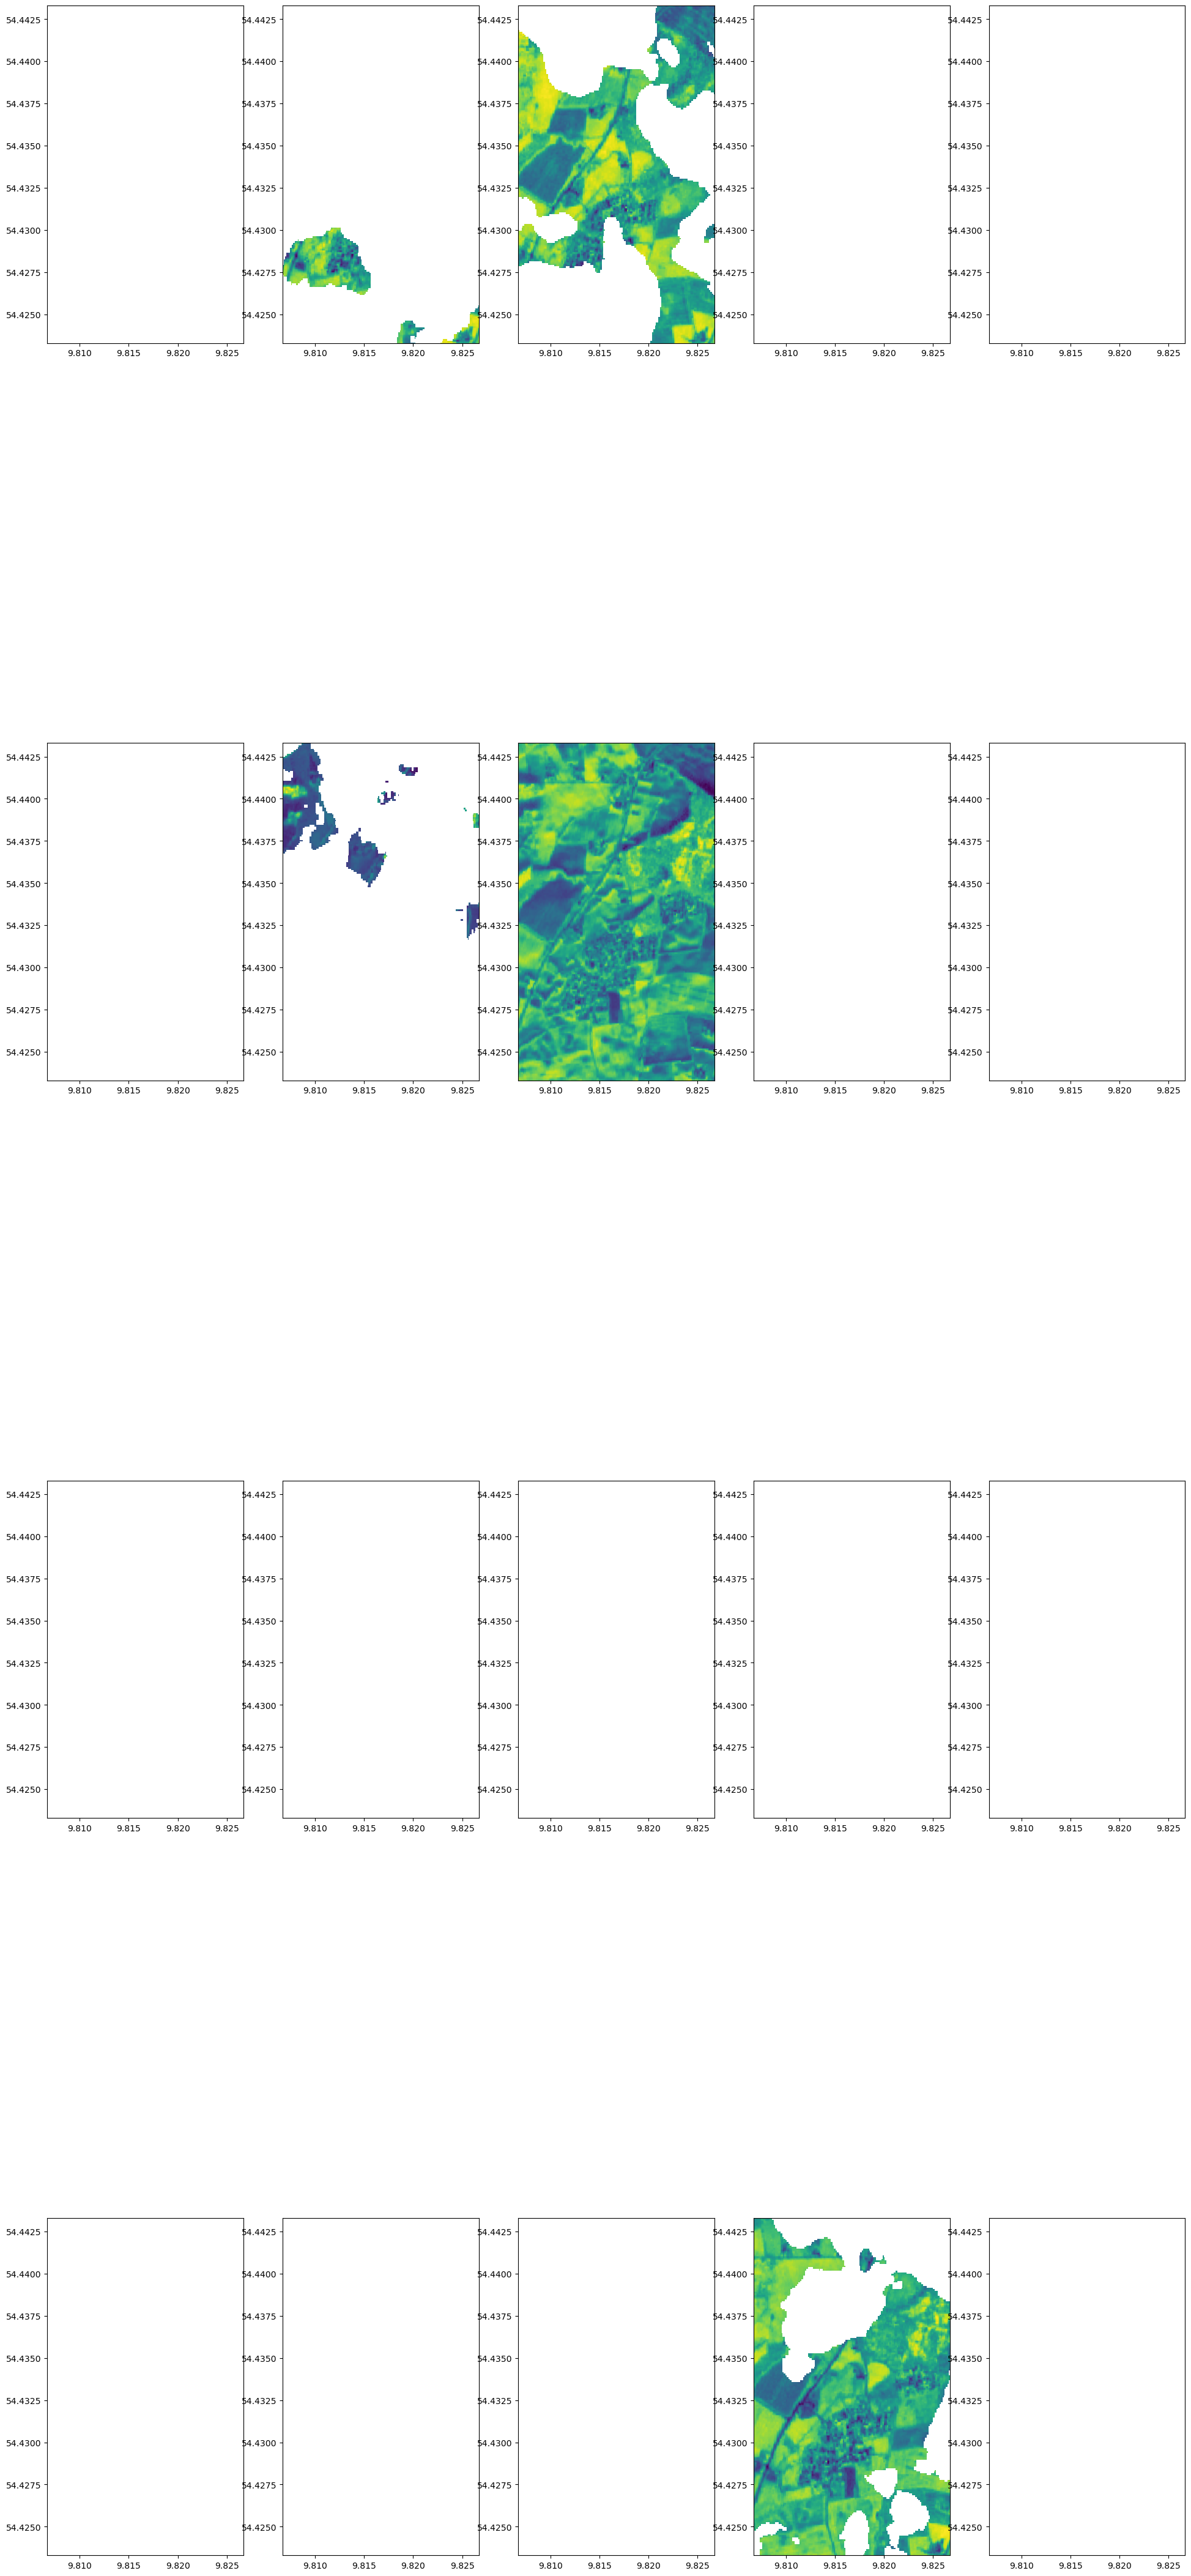

In [27]:
compare_images()

In [ ]:
    fig, axs = plt.subplots(figsize = (10, 10))
    box_width=0.02
    location = ee.Geometry.BBox(coord[1] - box_width, coord[0] - box_width, coord[1] + box_width, coord[0] + box_width)
    masked = csPlus_mask_collection(IC)
    img2ndImage=get_image_index(masked, 7)
    img2ndImage.geetools.plot(bands = ['NDVI'], ax = axs, region=location,cmap="viridis", #fc=points, 
                              color="red")
    cbar = fig.colorbar(axs.images[0], label="NDVI")
    fig, axs = plt.subplots(figsize = (10, 10))
    crop.geetools.plot(bands = ['classification'], fc=vectors, ax = axs, region=location,cmap="viridis", #fc=points, 
                              color="red")
    

In [6]:
def addNDVI(image, bands = ['sur_refl_b01', 'sur_refl_b02']):
    ndvi = image.normalizedDifference(bands).rename('ndvi')
    return image.addBands([ndvi])

In [98]:
class timeseries_downloader:
    def __init__(self, coords):
        self.coords = coords
        
    def initiate_image_collection(self, instrument = "COPERNICUS/S2_SR_HARMONIZED", bands = ['B4', 'B8'], 
                                  start_date = '2000-01-01', end_date = '2022-12-31', 
                                  QC_function = mask_s2_clouds_collection, pixel_scale = 500):
        self.bands = bands
        self.dataset = ee.ImageCollection(instrument).filterDate(start_date, end_date)
        self.dataset = QC_function(self.dataset)
        self.dataset = self.dataset.select(*bands)
        self.pixel_scale = pixel_scale
        
    def read_at_coords(self, box_width = 0.002):
        for coord_index, coord in enumerate(self.coords):
            print(coord_index)
            location = box_around_point(coord, box_width)
            filtered_dataset = self.dataset.filterBounds(location)
            filtered_dataset = reduce_region_collection(filtered_dataset, location, reducer_code = 'median', pixel_scale = self.pixel_scale)
            print('filtered!')
            df = collection_properties_to_frame(filtered_dataset, coord, self.bands, reducer_code = 'median')
            if coord_index == 0:
                self.df_full = df
            else:
                self.df_full = pd.concat([self.df_full, df])

def box_around_point(coord, box_width):
    '''
    coord: coordinate in (lat, lon) (?)
    '''
    return ee.Geometry.BBox(coord[1] - box_width, coord[0] - box_width, coord[1] + box_width, coord[0] + box_width)

def get_mean(image, location, pixel_scale= 500):
    return image.set('mean', image.reduceRegion(ee.Reducer.mean(), location , pixel_scale))

def get_median(image, location, pixel_scale= 500):
    return image.set('median', image.reduceRegion(ee.Reducer.median(), location , pixel_scale))

def reduce_region_collection(image_collection, location, reducer_code = 'median', pixel_scale = 500):
    if reducer_code == 'mean':
        return image_collection.map(lambda img: get_mean(img, location, pixel_scale = pixel_scale))
    elif reducer_code == 'median':
        return image_collection.map(lambda img: get_median(img, location, pixel_scale = pixel_scale))
    else:
        print('invalid reducer code')

def collection_properties_to_frame(image_collection, coord, bands, reducer_code = 'median'):
    print('collecting...')
    timelist = image_collection.aggregate_array('system:time_start').getInfo()
    print('Times retrieved!')
    bandlist = image_collection.aggregate_array(reducer_code).getInfo()
    print('Data retrieved!')
    data = {'Time': timelist,
            'lat': [coord[0] for count in range(len(timelist))],
            'lon': [coord[1] for count in range(len(timelist))],
            'Stations_Id': [np.int64(coord[2]) for count in range(len(timelist))]
           }
    for band in bands:
        data[f'{reducer_code} {band}'] = [band_data[band] for band_data in bandlist]
    df = pd.DataFrame(data)
    df['formatted_time'] = pd.to_datetime(df['Time'], unit='ms').dt.strftime('%Y-%m-%d-%H-%M-%S')
    return df